In [1]:
# import packages
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import datetime
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import interpn
from collections import defaultdict

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load data
items = pd.read_csv('data/ex_items.csv', sep = '|', parse_dates=['dateFirstSell'])
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,minSalesPrice,maxSalesPrice,meanSalesPrice,minSalesPriceCounts,maxSalesPriceCounts,unitsSold,revenue,relRevenue,dateFirstSell,dateLastSell,soldWeekly,soldMonthly
0,1,0,1,4.38,1,1-1,1-1-1,8.84,3.11,3.11,3.110000,690.0,690.0,690.0,2145.90,2.949022e-05,2018-01-23,2018-05-24,False,True
1,2,0,2,3.00,1,1-2,1-2-1,16.92,9.15,9.15,9.150000,5.0,5.0,5.0,45.75,6.287235e-07,2018-02-24,2018-05-29,False,False
2,3,0,3,5.00,1,1-3,1-3-1,15.89,9.89,14.04,11.918371,91.0,99.0,190.0,2289.95,3.146984e-05,2018-01-10,2018-05-16,False,False
3,4,0,2,4.44,1,1-2,1-2-1,40.17,13.01,13.01,13.010000,53.0,53.0,53.0,689.53,9.475928e-06,2018-01-18,2018-05-30,False,False
4,5,0,2,2.33,1,1-1,1-1-1,17.04,7.48,7.84,7.740377,49.0,128.0,177.0,1370.04,1.882790e-05,2018-01-06,2018-05-30,False,False


In [4]:
items_simple = items[['itemID', 'customerRating', 'manufacturer', 'brand', 'category1', 'category2', 'category3','recommendedRetailPrice', 'dateFirstSell', 'soldWeekly', 'soldMonthly']]

In [5]:
items_simple.category1 = pd.Categorical(items_simple.category1)
items_simple['category1'] = items_simple.category1.cat.codes
items_simple.category2 = pd.Categorical(items_simple.category2)
items_simple['category2'] = items_simple.category2.cat.codes
items_simple.category3 = pd.Categorical(items_simple.category3)
items_simple['category3'] = items_simple.category3.cat.codes
items_simple.head()

,itemID,customerRating,manufacturer,brand,category1,category2,category3,recommendedRetailPrice,dateFirstSell,soldWeekly,soldMonthly
0,1,4.38,1,0,0,0,0,8.84,2018-01-23,False,True
1,2,3.00,2,0,0,1,1,16.92,2018-02-24,False,False
2,3,5.00,3,0,0,2,2,15.89,2018-01-10,False,False
3,4,4.44,2,0,0,1,1,40.17,2018-01-18,False,False
4,5,2.33,2,0,0,0,0,17.04,2018-01-06,False,False


In [6]:
# load data
df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_train['date'] = [d.date() for d in df_train['time']]
df_test = pd.read_csv('data/orders0206_test.csv', sep='|', parse_dates=['time'])
df_test['date'] = [d.date() for d in df_test['time']]
df_items = pd.read_csv('data/items.csv', sep='|')

In [7]:
train = df_train
test = df_test
all_data = train.append(test)

In [8]:
# aggregate sales per day
aggregated = all_data.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
aggregated_sp = all_data.groupby(['itemID','date']).mean()["salesPrice"].to_frame().reset_index().rename(columns={'salesPrice':'avg_salesPrice'})

In [9]:
# # aggregate sales per day
# train_aggregated = train.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
# test_aggregated = test.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
# # aggregate sales per day
# train_aggregated_sp = train.groupby(['itemID','date']).mean()["salesPrice"].to_frame().reset_index().rename(columns={'salesPrice':'avg_salesPrice'})
# test_aggregated_sp = test.groupby(['itemID','date']).mean()["salesPrice"].to_frame().reset_index().rename(columns={'salesPrice':'avg_salesPrice'})

In [10]:
aggregated = pd.merge(aggregated,aggregated_sp,how='left')
aggregated.head()

,itemID,date,count,avg_salesPrice
0,1,2018-01-23,1,3.11
1,1,2018-01-25,1,3.11
2,1,2018-01-29,307,3.11
3,1,2018-01-30,3,3.11
4,1,2018-01-31,1,3.11


In [11]:
# (currently unused)
def add_datepart(df, fldname, drop=True):
#     https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1
    """Add additional date information to dataframe"""
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9 
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
import numpy as np
import re
# add additional date information
add_datepart(aggregated, 'date', drop = False)
add_datepart(aggregated, 'date', drop = False)

In [13]:
aggregated["WeekGroup"] = aggregated["Dayofyear"] // 14

In [14]:
aggregated.head()

,itemID,date,count,avg_salesPrice,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,WeekGroup
0,1,2018-01-23,1,3.11,2018,1,4,23,1,23,False,False,False,False,False,False,1516665600,1
1,1,2018-01-25,1,3.11,2018,1,4,25,3,25,False,False,False,False,False,False,1516838400,1
2,1,2018-01-29,307,3.11,2018,1,5,29,0,29,False,False,False,False,False,False,1517184000,2
3,1,2018-01-30,3,3.11,2018,1,5,30,1,30,False,False,False,False,False,False,1517270400,2
4,1,2018-01-31,1,3.11,2018,1,5,31,2,31,True,False,False,False,False,False,1517356800,2


In [15]:
from itertools import product
# Create "grid" with columns
index_cols = ['itemID', 'WeekGroup']

grid = []
for block_num in aggregated['WeekGroup'].unique():
    cur_items = aggregated.loc[aggregated['WeekGroup'] == block_num, 'itemID'].unique()
    grid.append(np.array(list(product(*[cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head()

,itemID,WeekGroup
0,1,1
1,3,1
2,4,1
3,5,1
4,8,1


In [16]:
train_m = aggregated.groupby(['WeekGroup','itemID']).agg({'count': 'sum','avg_salesPrice': np.mean}).reset_index()

# Merging sales numbers with the grid dataframe
train_m = pd.merge(grid,train_m,on=['WeekGroup','itemID'],how='left').fillna(0)

In [17]:
### add 0 sales for missing dates per itemID
for prod in train_m.itemID.unique():
    s = train_m.loc[train_m['itemID'] == prod][["WeekGroup","count","avg_salesPrice"]]
    s = s.set_index("WeekGroup")
    idx = range(s.index.min(), s.index.max()+1)
    s = s.reindex(idx)
#     s = s.reindex(idx, fill_value=0)
    if "df_week" not in globals():
        s["itemID"] = prod
        df_week = s
    else:
        s["itemID"] = prod
        df_week = pd.concat([df_week,s], ignore_index=False)
df_week.head(3)

,count,avg_salesPrice,itemID
WeekGroup,,,
1,2.0,3.11,1
2,314.0,3.11,1
3,35.0,3.11,1


In [18]:
df_week.reset_index(inplace=True)
df_week[df_week['itemID']==5]

,WeekGroup,count,avg_salesPrice,itemID
32,0,2.0,7.84,5
33,1,1.0,7.84,5
34,2,NaN,NaN,5
35,3,1.0,7.84,5
36,4,NaN,NaN,5
37,5,NaN,NaN,5
38,6,NaN,NaN,5
39,7,127.0,7.60,5
40,8,4.0,7.48,5
41,9,39.0,7.48,5


In [19]:
df_week.sort_values(by=['itemID', 'WeekGroup'], inplace=True)
df_week['count'].fillna(value=0, inplace=True)
# df_week['avg_salesPrice'].fillna(value=df_week.groupby('itemID')['avg_salesPrice'].transform('mean'), inplace=True)
# df_week['avg_salesPrice'].fillna(value=0, inplace=True)
df_week['avg_salesPrice'].fillna(method='ffill', inplace=True)

In [20]:
# adding the category id too from the items table.
df_m = pd.merge(df_week,items_simple,on=['itemID'],how='left')

In [21]:
df_m['dateFirstSell'] = [d.month for d in df_m['dateFirstSell']]

In [22]:
df_m['retail_price_diff'] = df_m.apply(lambda x: (x.avg_salesPrice - x.recommendedRetailPrice)/x.recommendedRetailPrice, axis = 1)
df_m['price_fluctuate'] = df_m.groupby('itemID').avg_salesPrice.shift(1)
df_m['price_fluctuate'] = df_m.groupby('itemID')['price_fluctuate'].fillna(method='bfill')
df_m['price_fluctuate'] = df_m.apply(lambda x: 0 if x.price_fluctuate == x.avg_salesPrice 
                                     else (-1 if x.price_fluctuate > x.avg_salesPrice else 1), axis = 1)

In [23]:
df_m[df_m['itemID']==5]

,WeekGroup,count,avg_salesPrice,itemID,customerRating,manufacturer,brand,category1,category2,category3,recommendedRetailPrice,dateFirstSell,soldWeekly,soldMonthly,retail_price_diff,price_fluctuate
40,0,2.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
41,1,1.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
42,2,0.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
43,3,1.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
44,4,0.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
45,5,0.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
46,6,0.0,7.84,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.539906,0
47,7,127.0,7.60,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.553991,-1
48,8,4.0,7.48,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.561033,-1
49,9,39.0,7.48,5,2.33,2,0,0,0,0,17.04,1.0,False,False,-0.561033,-1


In [24]:
groupcollist = ['brand','category1','category3']
aggregationlist = [('avg_salesPrice', np.mean, 'avg'),('count', np.sum, 'sum'),('count', np.mean, 'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = df_m.groupby([type_id,'WeekGroup']).aggregate(aggregator).reset_index()[[column_id,type_id,'WeekGroup']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'WeekGroup']
        # merge new columns on sales_m data
        df_m = pd.merge(df_m,mean_df,on=['WeekGroup',type_id],how='left')

In [25]:
df_m[df_m['itemID']==10]

,WeekGroup,count,avg_salesPrice,itemID,customerRating,manufacturer,brand,category1,category2,category3,...,price_fluctuate,brand_avg_avg_salesPrice,brand_sum_count,brand_avg_count,category1_avg_avg_salesPrice,category1_sum_count,category1_avg_count,category3_avg_avg_salesPrice,category3_sum_count,category3_avg_count
80,3,358.0,24.93,10,5.0,4,0,0,0,0,...,0,110.403893,50513.0,37.087372,173.732272,14960.0,20.662983,186.270195,7993.0,29.278388
81,4,1.0,24.17,10,5.0,4,0,0,0,0,...,-1,105.413338,166794.0,91.393973,172.738313,17638.0,20.677608,170.246632,6040.0,20.133333
82,5,63.0,24.17,10,5.0,4,0,0,0,0,...,0,100.894491,152878.0,71.072989,159.488239,17310.0,18.201893,177.237901,6070.0,18.119403
83,6,1.0,24.17,10,5.0,4,0,0,0,0,...,0,89.137772,94833.0,41.887367,151.009188,18572.0,18.553447,164.993007,5635.0,16.239193
84,7,1.0,24.17,10,5.0,4,0,0,0,0,...,0,87.233742,109424.0,45.104699,151.836020,12497.0,12.097773,162.932351,4656.0,13.042017
85,8,4.0,24.17,10,5.0,4,0,0,0,0,...,0,98.737129,165836.0,62.911988,154.494172,31784.0,27.423641,194.619652,14944.0,35.665871
86,9,0.0,24.17,10,5.0,4,0,0,0,0,...,0,76.857100,129284.0,49.935883,141.535865,17847.0,16.268915,140.704797,6725.0,17.558747
87,10,2.0,24.17,10,5.0,4,0,0,0,0,...,0,76.140829,128045.0,49.191318,131.974896,17342.0,17.641913,150.459923,4666.0,14.269113
88,11,1.0,24.17,10,5.0,4,0,0,0,0,...,0,58.250467,127225.0,60.210601,96.082644,15942.0,23.171512,105.455562,6904.0,29.504274


In [26]:
from sklearn.preprocessing import MinMaxScaler
# scale data between -1 & 1
scaler = MinMaxScaler()
scale_col = ['count', 'avg_salesPrice', 'customerRating', 'retail_price_diff', 
             'brand_avg_avg_salesPrice', 'brand_sum_count', 'brand_avg_count', 
             'category1_avg_avg_salesPrice', 'category1_sum_count', 'category1_avg_count', 
             'category3_avg_avg_salesPrice', 'category3_sum_count', 'category3_avg_count']
for c in scale_col:
    scaler.fit(df_m[[c]])
    df_m[c] = pd.DataFrame(scaler.transform(df_m[[c]]))[0]

In [27]:
df_m[df_m['itemID']==10]

,WeekGroup,count,avg_salesPrice,itemID,customerRating,manufacturer,brand,category1,category2,category3,...,price_fluctuate,brand_avg_avg_salesPrice,brand_sum_count,brand_avg_count,category1_avg_avg_salesPrice,category1_sum_count,category1_avg_count,category3_avg_avg_salesPrice,category3_sum_count,category3_avg_count
80,3,0.074135,0.002656,10,1.0,4,0,0,0,0,...,0,0.027008,0.302847,0.019748,0.368815,0.126926,0.069774,0.103880,0.130262,0.026755
81,4,0.000207,0.002575,10,1.0,4,0,0,0,0,...,-1,0.025772,1.000000,0.048666,0.366483,0.154043,0.069836,0.094880,0.098434,0.018398
82,5,0.013046,0.002575,10,1.0,4,0,0,0,0,...,0,0.024653,0.916568,0.037845,0.335389,0.150722,0.059325,0.098807,0.098923,0.016557
83,6,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0,0.021742,0.568564,0.022304,0.315492,0.163501,0.060818,0.091930,0.091834,0.014839
84,7,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0,0.021271,0.656043,0.024017,0.317432,0.101987,0.033410,0.090772,0.075879,0.011918
85,8,0.000828,0.002575,10,1.0,4,0,0,0,0,...,0,0.024119,0.994256,0.033499,0.323670,0.297282,0.098476,0.108569,0.243542,0.032591
86,9,0.000000,0.002575,10,1.0,4,0,0,0,0,...,0,0.018701,0.775112,0.026590,0.293261,0.156160,0.051119,0.078289,0.109597,0.016045
87,10,0.000414,0.002575,10,1.0,4,0,0,0,0,...,0,0.018524,0.767683,0.026193,0.270825,0.151046,0.056948,0.083767,0.076042,0.013039
88,11,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0,0.014094,0.762767,0.032061,0.186598,0.136870,0.080424,0.058491,0.112514,0.026961


In [28]:
lag_variables  = ['count','avg_salesPrice',
                  'brand_avg_avg_salesPrice','brand_sum_count','brand_avg_count',
#                   'manufacturer_avg_avg_salesPrice','manufacturer_sum_count','manufacturer_avg_count',
                  'category1_avg_avg_salesPrice','category1_sum_count','category1_avg_count',
                  'category3_avg_avg_salesPrice','category3_sum_count','category3_avg_count']
lags = [1 ,2 ,3, 4, 5]
# we will keep the results in thsi dataframe
sales_means = df_m.copy()
for lag in lags:
    sales_new_df = df_m.copy()
    sales_new_df.WeekGroup+=lag
    # subset only the lag variables we want
    sales_new_df = sales_new_df[['WeekGroup','itemID']+lag_variables]
    sales_new_df.columns = ['WeekGroup','itemID']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    # join with date_block_num,shop_id and item_id
    sales_means = pd.merge(sales_means, sales_new_df,on=['WeekGroup','itemID'] ,how='left')

In [29]:
for feat in sales_means.columns:
    if 'count' in feat:
        sales_means[feat]=sales_means[feat].fillna(0)
    elif 'salesPrice' or 'diff' in feat:
#         sales_means[feat]=sales_means[feat].fillna(sales_means[feat].median())
        sales_means[feat]=sales_means[feat].fillna(value=sales_means.groupby('itemID')[feat].transform('mean'))

In [30]:
sales_means[sales_means['itemID']==10]

,WeekGroup,count,avg_salesPrice,itemID,customerRating,manufacturer,brand,category1,category2,category3,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
80,3,0.074135,0.002656,10,1.0,4,0,0,0,0,...,0.002595,0.024794,0.000000,0.000000,0.346545,0.000000,0.000000,0.097374,0.000000,0.000000
81,4,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0.002595,0.024794,0.000000,0.000000,0.346545,0.000000,0.000000,0.097374,0.000000,0.000000
82,5,0.013046,0.002575,10,1.0,4,0,0,0,0,...,0.002595,0.024794,0.000000,0.000000,0.346545,0.000000,0.000000,0.097374,0.000000,0.000000
83,6,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0.002595,0.024794,0.000000,0.000000,0.346545,0.000000,0.000000,0.097374,0.000000,0.000000
84,7,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0.002595,0.024794,0.000000,0.000000,0.346545,0.000000,0.000000,0.097374,0.000000,0.000000
85,8,0.000828,0.002575,10,1.0,4,0,0,0,0,...,0.002656,0.027008,0.302847,0.019748,0.368815,0.126926,0.069774,0.103880,0.130262,0.026755
86,9,0.000000,0.002575,10,1.0,4,0,0,0,0,...,0.002575,0.025772,1.000000,0.048666,0.366483,0.154043,0.069836,0.094880,0.098434,0.018398
87,10,0.000414,0.002575,10,1.0,4,0,0,0,0,...,0.002575,0.024653,0.916568,0.037845,0.335389,0.150722,0.059325,0.098807,0.098923,0.016557
88,11,0.000207,0.002575,10,1.0,4,0,0,0,0,...,0.002575,0.021742,0.568564,0.022304,0.315492,0.163501,0.060818,0.091930,0.091834,0.014839


In [31]:
cols_to_drop = lag_variables[1:] + ['recommendedRetailPrice', 'category2', 'retail_price_diff', 'price_fluctuate']
for col in cols_to_drop:
    del sales_means[col]
sales_means

,WeekGroup,count,itemID,customerRating,manufacturer,brand,category1,category3,dateFirstSell,soldWeekly,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
0,1,0.000414,1,0.876,1,0,0,0,1.0,False,...,0.000331,0.024404,0.0,0.0,0.337255,0.0,0.0,0.090595,0.0,0.0
1,2,0.065024,1,0.876,1,0,0,0,1.0,False,...,0.000331,0.024404,0.0,0.0,0.337255,0.0,0.0,0.090595,0.0,0.0
2,3,0.007248,1,0.876,1,0,0,0,1.0,False,...,0.000331,0.024404,0.0,0.0,0.337255,0.0,0.0,0.090595,0.0,0.0
3,4,0.000414,1,0.876,1,0,0,0,1.0,False,...,0.000331,0.024404,0.0,0.0,0.337255,0.0,0.0,0.090595,0.0,0.0
4,5,0.000207,1,0.876,1,0,0,0,1.0,False,...,0.000331,0.024404,0.0,0.0,0.337255,0.0,0.0,0.090595,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46105,11,0.025264,10450,0.000,227,182,7,66,NaN,False,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
46106,8,0.000207,10459,0.000,253,180,7,66,5.0,False,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
46107,7,0.000207,10460,0.000,253,0,7,66,4.0,False,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
46108,8,0.000207,10462,0.000,253,180,7,66,4.0,False,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0


In [32]:
# sales_means = sales_means[sales_means['WeekGroup']>2]

In [33]:
X_train = sales_means[sales_means['WeekGroup']<9]
X_cv =  sales_means[sales_means['WeekGroup']==10]
X_test = sales_means[sales_means['WeekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['WeekGroup']
del X_cv['WeekGroup']
del X_test['WeekGroup']

In [34]:
del X_train['itemID']
del X_cv['itemID']

In [42]:
from xgboost import XGBRegressor
model = XGBRegressor(
    colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
   
    subsample= 0.7)
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_cv, Y_cv)], 
    verbose=True, 
    early_stopping_rounds = 10)

[17:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.48537	validation_1-rmse:0.48572
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48053	validation_1-rmse:0.48090
[2]	validation_0-rmse:0.47575	validation_1-rmse:0.47613
[3]	validation_0-rmse:0.47102	validation_1-rmse:0.47141
[4]	validation_0-rmse:0.46633	validation_1-rmse:0.46674
[5]	validation_0-rmse:0.46169	validation_1-rmse:0.46212
[6]	validation_0-rmse:0.45710	validation_1-rmse:0.45754
[7]	validation_0-rmse:0.45255	validation_1-rmse:0.45300
[8]	validation_0-rmse:0.44806	validation_1-rmse:0.44852
[9]	validation_0-rmse:0.44360	validation_1-rmse:0.44407
[10]	validation_0-rmse:0.43919	validation_1-rmse:0.43967
[11]	validation_0-rmse:0.43482	validation_1-rms

[138]	validation_0-rmse:0.12518	validation_1-rmse:0.12538
[139]	validation_0-rmse:0.12400	validation_1-rmse:0.12421
[140]	validation_0-rmse:0.12284	validation_1-rmse:0.12304
[141]	validation_0-rmse:0.12170	validation_1-rmse:0.12190
[142]	validation_0-rmse:0.12057	validation_1-rmse:0.12077
[143]	validation_0-rmse:0.11944	validation_1-rmse:0.11964
[144]	validation_0-rmse:0.11833	validation_1-rmse:0.11853
[145]	validation_0-rmse:0.11724	validation_1-rmse:0.11743
[146]	validation_0-rmse:0.11615	validation_1-rmse:0.11633
[147]	validation_0-rmse:0.11507	validation_1-rmse:0.11525
[148]	validation_0-rmse:0.11401	validation_1-rmse:0.11418
[149]	validation_0-rmse:0.11296	validation_1-rmse:0.11313
[150]	validation_0-rmse:0.11192	validation_1-rmse:0.11209
[151]	validation_0-rmse:0.11088	validation_1-rmse:0.11104
[152]	validation_0-rmse:0.10987	validation_1-rmse:0.11001
[153]	validation_0-rmse:0.10886	validation_1-rmse:0.10900
[154]	validation_0-rmse:0.10786	validation_1-rmse:0.10800
[155]	validati

[280]	validation_0-rmse:0.04260	validation_1-rmse:0.04199
[281]	validation_0-rmse:0.04240	validation_1-rmse:0.04179
[282]	validation_0-rmse:0.04221	validation_1-rmse:0.04159
[283]	validation_0-rmse:0.04201	validation_1-rmse:0.04138
[284]	validation_0-rmse:0.04182	validation_1-rmse:0.04118
[285]	validation_0-rmse:0.04164	validation_1-rmse:0.04099
[286]	validation_0-rmse:0.04145	validation_1-rmse:0.04080
[287]	validation_0-rmse:0.04127	validation_1-rmse:0.04061
[288]	validation_0-rmse:0.04109	validation_1-rmse:0.04043
[289]	validation_0-rmse:0.04091	validation_1-rmse:0.04025
[290]	validation_0-rmse:0.04073	validation_1-rmse:0.04007
[291]	validation_0-rmse:0.04056	validation_1-rmse:0.03989
[292]	validation_0-rmse:0.04039	validation_1-rmse:0.03971
[293]	validation_0-rmse:0.04023	validation_1-rmse:0.03954
[294]	validation_0-rmse:0.04006	validation_1-rmse:0.03938
[295]	validation_0-rmse:0.03990	validation_1-rmse:0.03921
[296]	validation_0-rmse:0.03974	validation_1-rmse:0.03905
[297]	validati

[422]	validation_0-rmse:0.03151	validation_1-rmse:0.03059
[423]	validation_0-rmse:0.03149	validation_1-rmse:0.03057
[424]	validation_0-rmse:0.03147	validation_1-rmse:0.03055
[425]	validation_0-rmse:0.03146	validation_1-rmse:0.03053
[426]	validation_0-rmse:0.03144	validation_1-rmse:0.03052
[427]	validation_0-rmse:0.03142	validation_1-rmse:0.03050
[428]	validation_0-rmse:0.03141	validation_1-rmse:0.03049
[429]	validation_0-rmse:0.03139	validation_1-rmse:0.03047
[430]	validation_0-rmse:0.03138	validation_1-rmse:0.03045
[431]	validation_0-rmse:0.03136	validation_1-rmse:0.03043
[432]	validation_0-rmse:0.03135	validation_1-rmse:0.03042
[433]	validation_0-rmse:0.03133	validation_1-rmse:0.03040
[434]	validation_0-rmse:0.03132	validation_1-rmse:0.03039
[435]	validation_0-rmse:0.03131	validation_1-rmse:0.03038
[436]	validation_0-rmse:0.03129	validation_1-rmse:0.03036
[437]	validation_0-rmse:0.03128	validation_1-rmse:0.03035
[438]	validation_0-rmse:0.03126	validation_1-rmse:0.03033
[439]	validati

[564]	validation_0-rmse:0.03049	validation_1-rmse:0.02971
[565]	validation_0-rmse:0.03049	validation_1-rmse:0.02971
[566]	validation_0-rmse:0.03049	validation_1-rmse:0.02971
[567]	validation_0-rmse:0.03049	validation_1-rmse:0.02971
[568]	validation_0-rmse:0.03048	validation_1-rmse:0.02970
[569]	validation_0-rmse:0.03048	validation_1-rmse:0.02970
[570]	validation_0-rmse:0.03048	validation_1-rmse:0.02970
[571]	validation_0-rmse:0.03048	validation_1-rmse:0.02970
[572]	validation_0-rmse:0.03047	validation_1-rmse:0.02970
[573]	validation_0-rmse:0.03047	validation_1-rmse:0.02970
[574]	validation_0-rmse:0.03047	validation_1-rmse:0.02970
[575]	validation_0-rmse:0.03047	validation_1-rmse:0.02970
[576]	validation_0-rmse:0.03046	validation_1-rmse:0.02970
[577]	validation_0-rmse:0.03046	validation_1-rmse:0.02970
[578]	validation_0-rmse:0.03046	validation_1-rmse:0.02970
[579]	validation_0-rmse:0.03046	validation_1-rmse:0.02970
[580]	validation_0-rmse:0.03046	validation_1-rmse:0.02970
[581]	validati

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=40, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=40, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=None)

In [43]:
import plotly_express as px
columns = X_train.columns
feature_importances = pd.DataFrame({'columns': columns,'importance':model.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance',ascending=False)
px.bar(feature_importances,x='columns',y='importance')

In [44]:
def evaluate_result(y: dict, y_pred: dict):
    monetary_value = 0
    y_pred = defaultdict(int, y_pred)  # return prediction of 0 for items without prediction
    
    for item in set(y_pred).difference(set(y)):
        y[item] = 0  # make sure that all items for which a demand has been predicted are contained in the actual demands
    
    for item, demand in y.items():
        predicted_demand = y_pred[item]
        price = product_prices[item]
        monetary_value += price * min(demand, predicted_demand)
        if predicted_demand > demand:
            monetary_value -= .6 * price * (predicted_demand - demand)
            
    return monetary_value

In [45]:
df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
df_items.head()

,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
itemID,,,,,,,
1,0,1,4.38,1,1,1,8.84
2,0,2,3.00,1,2,1,16.92
3,0,3,5.00,1,3,1,15.89
4,0,2,4.44,1,2,1,40.17
5,0,2,2.33,1,1,1,17.04


In [46]:
# actual demand
y = df_test.groupby(by='itemID')['order'].sum().to_dict()

# baseline 1 (average demand of previous 14 days)
y_baseline1 = df_train[df_train['time'] >= '2018-05-19'].groupby(by='itemID')['order'].sum().to_dict()

# baseline 2 (average demand of previous half year)
total_orders = df_train.groupby(by='itemID')['order'].sum().to_dict()
total_observed_days = (df_train['time'].dt.normalize().max() - df_train['time'].dt.normalize().min()).days
y_baseline2 = {item: orders / total_observed_days * 14 for item, orders in total_orders.items()}  # 14-day avg. demand

df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

In [47]:
# apply to unseen data
y_xgboost_all = dict()
for prod in X_test.itemID.unique():
    train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID'], axis=1))))).rename(columns={0:'predicted_count'})
    train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
    y_xgboost_all[prod] = int(train_predict["predicted_count"].sum().round())
#     if prod in df_train.itemID.unique():
#         y_xgboost_all[prod] = int(train_predict["predicted_count"].sum().round())
#     else:
#         y_xgboost_all[prod] = 0

In [48]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50


## Model per Cluster
1. Based on soldWeekly

In [50]:
y_xgboost_cat = dict()
for weekly in X_train.soldWeekly.unique(): 
    x_train_category = X_train[X_train.soldWeekly == weekly]#.drop(columns=["cluster","itemID"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.soldWeekly == weekly]#.drop(columns=["itemID","cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.soldWeekly == weekly].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID'], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_cat[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48679	validation_1-rmse:0.48581
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48194	validation_1-rmse:0.48097
[2]	validation_0-rmse:0.47713	validation_1-rmse:0.47618
[3]	validation_0-rmse:0.47238	validation_1-rmse:0.47144
[4]	validation_0-rmse:0.46768	validation_1-rmse:0.46675
[5]	validation_0-rmse:0.46302	validation_1-rmse:0.46210
[6]	validation_0-rmse:0.45840	validation_1-rmse:0.45748
[7]	validation_0-rmse:0.45384	validation_1-rmse:0.45293
[8]	validation_0-rmse:0.44932	validation_1-rmse:0.44841
[9]	validation_0-rmse:0.44485	validation_1-rmse:0.44394
[10]	validation_0-rmse:0.44041	validation_1-rmse:0.43952
[11]	validation_0-rmse:0.43603	validation_1-rmse:0.43515
[12]	validation_0-rmse:0.43169	validation_1-rmse:0.43081
[13]	validation_0-rmse:0.42739	validation_1-rmse:0.42652
[14]	validation_0-rmse:0.42314	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12094	validation_1-rmse:0.11990
[142]	validation_0-rmse:0.11979	validation_1-rmse:0.11875
[143]	validation_0-rmse:0.11865	validation_1-rmse:0.11761
[144]	validation_0-rmse:0.11752	validation_1-rmse:0.11649
[145]	validation_0-rmse:0.11641	validation_1-rmse:0.11537
[146]	validation_0-rmse:0.11531	validation_1-rmse:0.11427
[147]	validation_0-rmse:0.11422	validation_1-rmse:0.11317
[148]	validation_0-rmse:0.11314	validation_1-rmse:0.11208
[149]	validation_0-rmse:0.11207	validation_1-rmse:0.11101
[150]	validation_0-rmse:0.11101	validation_1-rmse:0.10995
[151]	validation_0-rmse:0.10997	validation_1-rmse:0.10891
[152]	validation_0-rmse:0.10894	validation_1-rmse:0.10787
[153]	validation_0-rmse:0.10791	validation_1-rmse:0.10684
[154]	validation_0-rmse:0.10690	validation_1-rmse:0.10583
[155]	validation_0-rmse:0.10590	validation_1-rmse:0.10482
[156]	validation_0-rmse:0.10491	validation_1-rmse:0.10383
[157]	validation_0-rmse:0.10393	validation_1-rmse:0.10284
[158]	validati

[283]	validation_0-rmse:0.03873	validation_1-rmse:0.03746
[284]	validation_0-rmse:0.03852	validation_1-rmse:0.03726
[285]	validation_0-rmse:0.03831	validation_1-rmse:0.03705
[286]	validation_0-rmse:0.03811	validation_1-rmse:0.03685
[287]	validation_0-rmse:0.03791	validation_1-rmse:0.03665
[288]	validation_0-rmse:0.03772	validation_1-rmse:0.03645
[289]	validation_0-rmse:0.03752	validation_1-rmse:0.03626
[290]	validation_0-rmse:0.03733	validation_1-rmse:0.03606
[291]	validation_0-rmse:0.03714	validation_1-rmse:0.03588
[292]	validation_0-rmse:0.03696	validation_1-rmse:0.03570
[293]	validation_0-rmse:0.03678	validation_1-rmse:0.03552
[294]	validation_0-rmse:0.03660	validation_1-rmse:0.03534
[295]	validation_0-rmse:0.03642	validation_1-rmse:0.03516
[296]	validation_0-rmse:0.03624	validation_1-rmse:0.03499
[297]	validation_0-rmse:0.03607	validation_1-rmse:0.03482
[298]	validation_0-rmse:0.03590	validation_1-rmse:0.03465
[299]	validation_0-rmse:0.03574	validation_1-rmse:0.03448
[300]	validati

[425]	validation_0-rmse:0.02696	validation_1-rmse:0.02599
[426]	validation_0-rmse:0.02694	validation_1-rmse:0.02597
[427]	validation_0-rmse:0.02692	validation_1-rmse:0.02596
[428]	validation_0-rmse:0.02691	validation_1-rmse:0.02594
[429]	validation_0-rmse:0.02689	validation_1-rmse:0.02593
[430]	validation_0-rmse:0.02687	validation_1-rmse:0.02591
[431]	validation_0-rmse:0.02685	validation_1-rmse:0.02590
[432]	validation_0-rmse:0.02684	validation_1-rmse:0.02588
[433]	validation_0-rmse:0.02682	validation_1-rmse:0.02587
[434]	validation_0-rmse:0.02680	validation_1-rmse:0.02586
[435]	validation_0-rmse:0.02679	validation_1-rmse:0.02584
[436]	validation_0-rmse:0.02677	validation_1-rmse:0.02583
[437]	validation_0-rmse:0.02676	validation_1-rmse:0.02582
[438]	validation_0-rmse:0.02674	validation_1-rmse:0.02581
[439]	validation_0-rmse:0.02673	validation_1-rmse:0.02580
[440]	validation_0-rmse:0.02671	validation_1-rmse:0.02578
[441]	validation_0-rmse:0.02670	validation_1-rmse:0.02577
[442]	validati

[567]	validation_0-rmse:0.02591	validation_1-rmse:0.02524
[568]	validation_0-rmse:0.02591	validation_1-rmse:0.02525
[569]	validation_0-rmse:0.02591	validation_1-rmse:0.02525
[570]	validation_0-rmse:0.02590	validation_1-rmse:0.02525
[571]	validation_0-rmse:0.02590	validation_1-rmse:0.02525
[572]	validation_0-rmse:0.02590	validation_1-rmse:0.02525
[573]	validation_0-rmse:0.02590	validation_1-rmse:0.02525
[574]	validation_0-rmse:0.02590	validation_1-rmse:0.02525
Stopping. Best iteration:
[564]	validation_0-rmse:0.02592	validation_1-rmse:0.02524

[0]	validation_0-rmse:0.46166	validation_1-rmse:0.48479
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.45718	validation_1-rmse:0.48027
[2]	validation_0-rmse:0.45276	validation_1-rmse:0.47579
[3]	validation_0-rmse:0.44839	validation_1-rmse:0.47138
[4]	validation_0-rmse:0.44405	validation_1-rmse:0.46687
[5]	validati

[131]	validation_0-rmse:0.14362	validation_1-rmse:0.14999
[132]	validation_0-rmse:0.14258	validation_1-rmse:0.14882
[133]	validation_0-rmse:0.14155	validation_1-rmse:0.14767
[134]	validation_0-rmse:0.14054	validation_1-rmse:0.14653
[135]	validation_0-rmse:0.13953	validation_1-rmse:0.14537
[136]	validation_0-rmse:0.13853	validation_1-rmse:0.14419
[137]	validation_0-rmse:0.13755	validation_1-rmse:0.14306
[138]	validation_0-rmse:0.13657	validation_1-rmse:0.14195
[139]	validation_0-rmse:0.13563	validation_1-rmse:0.14084
[140]	validation_0-rmse:0.13467	validation_1-rmse:0.13977
[141]	validation_0-rmse:0.13375	validation_1-rmse:0.13875
[142]	validation_0-rmse:0.13283	validation_1-rmse:0.13767
[143]	validation_0-rmse:0.13192	validation_1-rmse:0.13665
[144]	validation_0-rmse:0.13103	validation_1-rmse:0.13559
[145]	validation_0-rmse:0.13014	validation_1-rmse:0.13452
[146]	validation_0-rmse:0.12926	validation_1-rmse:0.13348
[147]	validation_0-rmse:0.12841	validation_1-rmse:0.13249
[148]	validati

[273]	validation_0-rmse:0.07924	validation_1-rmse:0.06925
[274]	validation_0-rmse:0.07914	validation_1-rmse:0.06908
[275]	validation_0-rmse:0.07902	validation_1-rmse:0.06889
[276]	validation_0-rmse:0.07890	validation_1-rmse:0.06872
[277]	validation_0-rmse:0.07879	validation_1-rmse:0.06854
[278]	validation_0-rmse:0.07867	validation_1-rmse:0.06834
[279]	validation_0-rmse:0.07857	validation_1-rmse:0.06818
[280]	validation_0-rmse:0.07846	validation_1-rmse:0.06801
[281]	validation_0-rmse:0.07836	validation_1-rmse:0.06783
[282]	validation_0-rmse:0.07827	validation_1-rmse:0.06768
[283]	validation_0-rmse:0.07817	validation_1-rmse:0.06753
[284]	validation_0-rmse:0.07807	validation_1-rmse:0.06739
[285]	validation_0-rmse:0.07797	validation_1-rmse:0.06721
[286]	validation_0-rmse:0.07787	validation_1-rmse:0.06706
[287]	validation_0-rmse:0.07779	validation_1-rmse:0.06689
[288]	validation_0-rmse:0.07768	validation_1-rmse:0.06674
[289]	validation_0-rmse:0.07759	validation_1-rmse:0.06658
[290]	validati

[415]	validation_0-rmse:0.07283	validation_1-rmse:0.05824
[416]	validation_0-rmse:0.07281	validation_1-rmse:0.05822
[417]	validation_0-rmse:0.07280	validation_1-rmse:0.05820
[418]	validation_0-rmse:0.07279	validation_1-rmse:0.05818
[419]	validation_0-rmse:0.07278	validation_1-rmse:0.05815
[420]	validation_0-rmse:0.07276	validation_1-rmse:0.05811
[421]	validation_0-rmse:0.07275	validation_1-rmse:0.05808
[422]	validation_0-rmse:0.07274	validation_1-rmse:0.05805
[423]	validation_0-rmse:0.07272	validation_1-rmse:0.05803
[424]	validation_0-rmse:0.07271	validation_1-rmse:0.05801
[425]	validation_0-rmse:0.07270	validation_1-rmse:0.05801
[426]	validation_0-rmse:0.07268	validation_1-rmse:0.05798
[427]	validation_0-rmse:0.07267	validation_1-rmse:0.05795
[428]	validation_0-rmse:0.07266	validation_1-rmse:0.05792
[429]	validation_0-rmse:0.07265	validation_1-rmse:0.05790
[430]	validation_0-rmse:0.07264	validation_1-rmse:0.05786
[431]	validation_0-rmse:0.07263	validation_1-rmse:0.05786
[432]	validati

[557]	validation_0-rmse:0.07178	validation_1-rmse:0.05679
[558]	validation_0-rmse:0.07178	validation_1-rmse:0.05678
[559]	validation_0-rmse:0.07178	validation_1-rmse:0.05678
[560]	validation_0-rmse:0.07177	validation_1-rmse:0.05678
[561]	validation_0-rmse:0.07176	validation_1-rmse:0.05677
[562]	validation_0-rmse:0.07176	validation_1-rmse:0.05678
[563]	validation_0-rmse:0.07175	validation_1-rmse:0.05677
[564]	validation_0-rmse:0.07175	validation_1-rmse:0.05677
[565]	validation_0-rmse:0.07175	validation_1-rmse:0.05677
[566]	validation_0-rmse:0.07174	validation_1-rmse:0.05674
[567]	validation_0-rmse:0.07173	validation_1-rmse:0.05673
[568]	validation_0-rmse:0.07173	validation_1-rmse:0.05672
[569]	validation_0-rmse:0.07172	validation_1-rmse:0.05671
[570]	validation_0-rmse:0.07172	validation_1-rmse:0.05671
[571]	validation_0-rmse:0.07172	validation_1-rmse:0.05671
[572]	validation_0-rmse:0.07172	validation_1-rmse:0.05670
[573]	validation_0-rmse:0.07171	validation_1-rmse:0.05670
[574]	validati

In [53]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27


2. Based on soldMonthly

In [52]:
y_xgboost_mon = dict()
for monthly in X_train.soldMonthly.unique(): 
    x_train_category = X_train[X_train.soldMonthly == monthly]#.drop(columns=["cluster","itemID"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.soldMonthly == monthly]#.drop(columns=["itemID","cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.soldMonthly == monthly].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID'], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_mon[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48341	validation_1-rmse:0.48802
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.47860	validation_1-rmse:0.48322
[2]	validation_0-rmse:0.47385	validation_1-rmse:0.47847
[3]	validation_0-rmse:0.46915	validation_1-rmse:0.47379
[4]	validation_0-rmse:0.46449	validation_1-rmse:0.46915
[5]	validation_0-rmse:0.45988	validation_1-rmse:0.46456
[6]	validation_0-rmse:0.45531	validation_1-rmse:0.45998
[7]	validation_0-rmse:0.45080	validation_1-rmse:0.45547
[8]	validation_0-rmse:0.44633	validation_1-rmse:0.45099
[9]	validation_0-rmse:0.44190	validation_1-rmse:0.44655
[10]	validation_0-rmse:0.43751	validation_1-rmse:0.44217
[11]	validation_0-rmse:0.43318	validation_1-rmse:0.43784
[12]	validation_0-rmse:0.42888	validation_1-rmse:0.43354
[13]	validation_0-rmse:0.42463	validation_1-rmse:0.42931
[14]	validation_0-rmse:0.42042	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12296	validation_1-rmse:0.12638
[142]	validation_0-rmse:0.12185	validation_1-rmse:0.12528
[143]	validation_0-rmse:0.12075	validation_1-rmse:0.12417
[144]	validation_0-rmse:0.11966	validation_1-rmse:0.12306
[145]	validation_0-rmse:0.11859	validation_1-rmse:0.12197
[146]	validation_0-rmse:0.11752	validation_1-rmse:0.12088
[147]	validation_0-rmse:0.11647	validation_1-rmse:0.11982
[148]	validation_0-rmse:0.11543	validation_1-rmse:0.11876
[149]	validation_0-rmse:0.11440	validation_1-rmse:0.11772
[150]	validation_0-rmse:0.11338	validation_1-rmse:0.11668
[151]	validation_0-rmse:0.11237	validation_1-rmse:0.11565
[152]	validation_0-rmse:0.11137	validation_1-rmse:0.11463
[153]	validation_0-rmse:0.11038	validation_1-rmse:0.11362
[154]	validation_0-rmse:0.10941	validation_1-rmse:0.11263
[155]	validation_0-rmse:0.10845	validation_1-rmse:0.11164
[156]	validation_0-rmse:0.10750	validation_1-rmse:0.11070
[157]	validation_0-rmse:0.10655	validation_1-rmse:0.10974
[158]	validati

[283]	validation_0-rmse:0.04673	validation_1-rmse:0.04776
[284]	validation_0-rmse:0.04656	validation_1-rmse:0.04757
[285]	validation_0-rmse:0.04639	validation_1-rmse:0.04738
[286]	validation_0-rmse:0.04623	validation_1-rmse:0.04720
[287]	validation_0-rmse:0.04607	validation_1-rmse:0.04702
[288]	validation_0-rmse:0.04590	validation_1-rmse:0.04685
[289]	validation_0-rmse:0.04575	validation_1-rmse:0.04668
[290]	validation_0-rmse:0.04559	validation_1-rmse:0.04651
[291]	validation_0-rmse:0.04543	validation_1-rmse:0.04634
[292]	validation_0-rmse:0.04528	validation_1-rmse:0.04617
[293]	validation_0-rmse:0.04514	validation_1-rmse:0.04600
[294]	validation_0-rmse:0.04499	validation_1-rmse:0.04584
[295]	validation_0-rmse:0.04485	validation_1-rmse:0.04568
[296]	validation_0-rmse:0.04471	validation_1-rmse:0.04552
[297]	validation_0-rmse:0.04457	validation_1-rmse:0.04536
[298]	validation_0-rmse:0.04443	validation_1-rmse:0.04521
[299]	validation_0-rmse:0.04430	validation_1-rmse:0.04507
[300]	validati

[425]	validation_0-rmse:0.03744	validation_1-rmse:0.03687
[426]	validation_0-rmse:0.03743	validation_1-rmse:0.03685
[427]	validation_0-rmse:0.03742	validation_1-rmse:0.03684
[428]	validation_0-rmse:0.03740	validation_1-rmse:0.03682
[429]	validation_0-rmse:0.03739	validation_1-rmse:0.03680
[430]	validation_0-rmse:0.03737	validation_1-rmse:0.03678
[431]	validation_0-rmse:0.03736	validation_1-rmse:0.03676
[432]	validation_0-rmse:0.03734	validation_1-rmse:0.03676
[433]	validation_0-rmse:0.03733	validation_1-rmse:0.03674
[434]	validation_0-rmse:0.03731	validation_1-rmse:0.03672
[435]	validation_0-rmse:0.03730	validation_1-rmse:0.03670
[436]	validation_0-rmse:0.03729	validation_1-rmse:0.03669
[437]	validation_0-rmse:0.03728	validation_1-rmse:0.03668
[438]	validation_0-rmse:0.03727	validation_1-rmse:0.03666
[439]	validation_0-rmse:0.03726	validation_1-rmse:0.03664
[440]	validation_0-rmse:0.03724	validation_1-rmse:0.03663
[441]	validation_0-rmse:0.03723	validation_1-rmse:0.03661
[442]	validati

[567]	validation_0-rmse:0.03651	validation_1-rmse:0.03585
[568]	validation_0-rmse:0.03650	validation_1-rmse:0.03585
[569]	validation_0-rmse:0.03650	validation_1-rmse:0.03584
[570]	validation_0-rmse:0.03650	validation_1-rmse:0.03584
[571]	validation_0-rmse:0.03649	validation_1-rmse:0.03584
[572]	validation_0-rmse:0.03649	validation_1-rmse:0.03584
[573]	validation_0-rmse:0.03649	validation_1-rmse:0.03584
[574]	validation_0-rmse:0.03649	validation_1-rmse:0.03584
[575]	validation_0-rmse:0.03648	validation_1-rmse:0.03584
[576]	validation_0-rmse:0.03648	validation_1-rmse:0.03583
[577]	validation_0-rmse:0.03648	validation_1-rmse:0.03584
[578]	validation_0-rmse:0.03647	validation_1-rmse:0.03584
[579]	validation_0-rmse:0.03647	validation_1-rmse:0.03584
[580]	validation_0-rmse:0.03647	validation_1-rmse:0.03583
[581]	validation_0-rmse:0.03646	validation_1-rmse:0.03583
[582]	validation_0-rmse:0.03646	validation_1-rmse:0.03583
[583]	validation_0-rmse:0.03646	validation_1-rmse:0.03583
[584]	validati

[104]	validation_0-rmse:0.17288	validation_1-rmse:0.17106
[105]	validation_0-rmse:0.17119	validation_1-rmse:0.16940
[106]	validation_0-rmse:0.16951	validation_1-rmse:0.16775
[107]	validation_0-rmse:0.16785	validation_1-rmse:0.16609
[108]	validation_0-rmse:0.16620	validation_1-rmse:0.16448
[109]	validation_0-rmse:0.16457	validation_1-rmse:0.16287
[110]	validation_0-rmse:0.16296	validation_1-rmse:0.16125
[111]	validation_0-rmse:0.16136	validation_1-rmse:0.15971
[112]	validation_0-rmse:0.15978	validation_1-rmse:0.15815
[113]	validation_0-rmse:0.15822	validation_1-rmse:0.15660
[114]	validation_0-rmse:0.15667	validation_1-rmse:0.15508
[115]	validation_0-rmse:0.15514	validation_1-rmse:0.15356
[116]	validation_0-rmse:0.15362	validation_1-rmse:0.15207
[117]	validation_0-rmse:0.15212	validation_1-rmse:0.15058
[118]	validation_0-rmse:0.15064	validation_1-rmse:0.14910
[119]	validation_0-rmse:0.14917	validation_1-rmse:0.14764
[120]	validation_0-rmse:0.14771	validation_1-rmse:0.14619
[121]	validati

[246]	validation_0-rmse:0.04699	validation_1-rmse:0.04767
[247]	validation_0-rmse:0.04662	validation_1-rmse:0.04732
[248]	validation_0-rmse:0.04627	validation_1-rmse:0.04696
[249]	validation_0-rmse:0.04592	validation_1-rmse:0.04663
[250]	validation_0-rmse:0.04557	validation_1-rmse:0.04631
[251]	validation_0-rmse:0.04522	validation_1-rmse:0.04597
[252]	validation_0-rmse:0.04488	validation_1-rmse:0.04565
[253]	validation_0-rmse:0.04455	validation_1-rmse:0.04533
[254]	validation_0-rmse:0.04422	validation_1-rmse:0.04502
[255]	validation_0-rmse:0.04389	validation_1-rmse:0.04471
[256]	validation_0-rmse:0.04356	validation_1-rmse:0.04439
[257]	validation_0-rmse:0.04324	validation_1-rmse:0.04409
[258]	validation_0-rmse:0.04293	validation_1-rmse:0.04379
[259]	validation_0-rmse:0.04262	validation_1-rmse:0.04348
[260]	validation_0-rmse:0.04231	validation_1-rmse:0.04319
[261]	validation_0-rmse:0.04201	validation_1-rmse:0.04290
[262]	validation_0-rmse:0.04171	validation_1-rmse:0.04262
[263]	validati

[388]	validation_0-rmse:0.02436	validation_1-rmse:0.02709
[389]	validation_0-rmse:0.02432	validation_1-rmse:0.02705
[390]	validation_0-rmse:0.02428	validation_1-rmse:0.02702
[391]	validation_0-rmse:0.02423	validation_1-rmse:0.02698
[392]	validation_0-rmse:0.02420	validation_1-rmse:0.02696
[393]	validation_0-rmse:0.02416	validation_1-rmse:0.02693
[394]	validation_0-rmse:0.02412	validation_1-rmse:0.02690
[395]	validation_0-rmse:0.02408	validation_1-rmse:0.02687
[396]	validation_0-rmse:0.02405	validation_1-rmse:0.02685
[397]	validation_0-rmse:0.02401	validation_1-rmse:0.02682
[398]	validation_0-rmse:0.02397	validation_1-rmse:0.02679
[399]	validation_0-rmse:0.02394	validation_1-rmse:0.02676
[400]	validation_0-rmse:0.02390	validation_1-rmse:0.02673
[401]	validation_0-rmse:0.02387	validation_1-rmse:0.02670
[402]	validation_0-rmse:0.02384	validation_1-rmse:0.02668
[403]	validation_0-rmse:0.02380	validation_1-rmse:0.02665
[404]	validation_0-rmse:0.02377	validation_1-rmse:0.02662
[405]	validati

[530]	validation_0-rmse:0.02217	validation_1-rmse:0.02554
[531]	validation_0-rmse:0.02216	validation_1-rmse:0.02553
[532]	validation_0-rmse:0.02216	validation_1-rmse:0.02554
[533]	validation_0-rmse:0.02216	validation_1-rmse:0.02554
[534]	validation_0-rmse:0.02215	validation_1-rmse:0.02553
[535]	validation_0-rmse:0.02215	validation_1-rmse:0.02553
[536]	validation_0-rmse:0.02215	validation_1-rmse:0.02553
[537]	validation_0-rmse:0.02214	validation_1-rmse:0.02553
[538]	validation_0-rmse:0.02214	validation_1-rmse:0.02553
[539]	validation_0-rmse:0.02213	validation_1-rmse:0.02553
[540]	validation_0-rmse:0.02213	validation_1-rmse:0.02553
[541]	validation_0-rmse:0.02213	validation_1-rmse:0.02553
[542]	validation_0-rmse:0.02213	validation_1-rmse:0.02553
[543]	validation_0-rmse:0.02212	validation_1-rmse:0.02553
[544]	validation_0-rmse:0.02212	validation_1-rmse:0.02552
[545]	validation_0-rmse:0.02211	validation_1-rmse:0.02552
[546]	validation_0-rmse:0.02211	validation_1-rmse:0.02552
[547]	validati

In [54]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')
print(f'XGBoost by monthly: {evaluate_result(y, y_xgboost_mon):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27
XGBoost by monthly: 790516.54


3. With Clusters

In [83]:
X_train = sales_means[sales_means['WeekGroup']<9]
X_cv =  sales_means[sales_means['WeekGroup']==10]
X_test = sales_means[sales_means['WeekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['WeekGroup']
del X_cv['WeekGroup']
del X_test['WeekGroup']

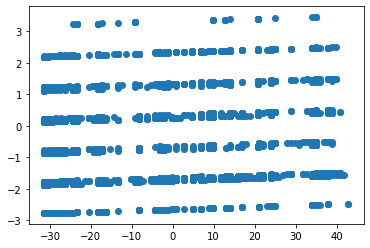

In [84]:
X_train_items = sales_means[["itemID","soldWeekly","soldMonthly","category1","category3","dateFirstSell"]].drop_duplicates().fillna(0)
X_train_items = X_train_items.reset_index()
X_train_items = X_train_items.drop(columns=["index"])
a_pca = PCA(n_components=2).fit_transform(X_train_items.drop(columns=["itemID"]))
df_pca = pd.DataFrame(data=a_pca) 
plot2 = plt.scatter( df_pca[0], df_pca[1])

In [85]:
from sklearn.cluster import KMeans
estimator = KMeans(n_clusters = 3)
cluster = estimator.fit(df_pca[[0,1]])
cluster_ids = estimator.predict(df_pca[[0,1]])
# plt.scatter(df_pca[0],df_pca[1], c=cluster_ids)

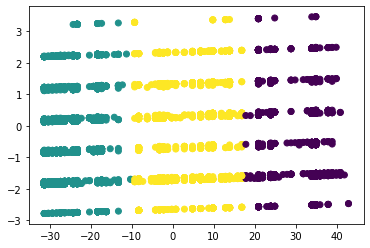

In [86]:
df_pca["itemID"] = X_train_items.itemID
df_pca["cluster"] = cluster_ids#df_pca.apply(lambda x: 1 if x[1] > 2 else 2 if x[1] > 1 else 3 if x[1] > 0 else 4 if x[1] > -1 else 5 if x[1] > -2 else 6 , axis = 1)
plt.scatter(df_pca[0],df_pca[1], c=df_pca.cluster)

In [87]:
df_pca = df_pca.set_index("itemID")
X_train = X_train.join(df_pca[["cluster"]], on='itemID', how="left")
X_train.cluster = X_train.cluster.fillna(0)
X_test = X_test.join(df_pca[["cluster"]], on='itemID', how="left")
X_test.cluster = X_test.cluster.fillna(0)
X_cv = X_cv.join(df_pca[["cluster"]], on='itemID', how="left")
X_cv.cluster = X_cv.cluster.fillna(0)
X_train.groupby("cluster").count()

,itemID,customerRating,manufacturer,brand,category1,category3,dateFirstSell,soldWeekly,soldMonthly,count_lag_1,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
cluster,,,,,,,,,,,,,,,,,,,,,
0,9143,9143,9143,9143,9143,9143,9143,9143,9143,9143,...,7278,7278,9143,9143,7278,9143,9143,7278,9143,9143
1,12879,12879,12879,12879,12879,12879,12879,12879,12879,12879,...,10090,10090,12879,12879,10090,12879,12879,10090,12879,12879
2,9216,9216,9216,9216,9216,9216,9216,9216,9216,9216,...,7071,7071,9216,9216,7071,9216,9216,7071,9216,9216


In [88]:
del X_train['itemID']
del X_cv['itemID']

In [89]:
y_xgboost_cluster = dict()
for cluster in df_pca.cluster.unique(): 
    x_train_category = X_train[X_train.cluster == cluster].drop(columns=["cluster"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.cluster == cluster].drop(columns=["cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.cluster == cluster].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID',"cluster"], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_cluster[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48856	validation_1-rmse:0.48798
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48368	validation_1-rmse:0.48309
[2]	validation_0-rmse:0.47885	validation_1-rmse:0.47825
[3]	validation_0-rmse:0.47406	validation_1-rmse:0.47346
[4]	validation_0-rmse:0.46933	validation_1-rmse:0.46871
[5]	validation_0-rmse:0.46464	validation_1-rmse:0.46401
[6]	validation_0-rmse:0.46000	validation_1-rmse:0.45937
[7]	validation_0-rmse:0.45541	validation_1-rmse:0.45476
[8]	validation_0-rmse:0.45086	validation_1-rmse:0.45021
[9]	validation_0-rmse:0.44635	validation_1-rmse:0.44569
[10]	validation_0-rmse:0.44190	validation_1-rmse:0.44123
[11]	validation_0-rmse:0.43749	validation_1-rmse:0.43681
[12]	validation_0-rmse:0.43312	validation_1-rmse:0.43243
[13]	validation_0-rmse:0.42879	validation_1-rmse:0.42809
[14]	validation_0-rmse:0.42451	validation_1-rmse:0.42

[141]	validation_0-rmse:0.11944	validation_1-rmse:0.11841
[142]	validation_0-rmse:0.11826	validation_1-rmse:0.11723
[143]	validation_0-rmse:0.11710	validation_1-rmse:0.11605
[144]	validation_0-rmse:0.11595	validation_1-rmse:0.11491
[145]	validation_0-rmse:0.11481	validation_1-rmse:0.11378
[146]	validation_0-rmse:0.11369	validation_1-rmse:0.11265
[147]	validation_0-rmse:0.11257	validation_1-rmse:0.11154
[148]	validation_0-rmse:0.11147	validation_1-rmse:0.11043
[149]	validation_0-rmse:0.11037	validation_1-rmse:0.10934
[150]	validation_0-rmse:0.10929	validation_1-rmse:0.10827
[151]	validation_0-rmse:0.10822	validation_1-rmse:0.10719
[152]	validation_0-rmse:0.10716	validation_1-rmse:0.10613
[153]	validation_0-rmse:0.10611	validation_1-rmse:0.10508
[154]	validation_0-rmse:0.10507	validation_1-rmse:0.10405
[155]	validation_0-rmse:0.10405	validation_1-rmse:0.10302
[156]	validation_0-rmse:0.10303	validation_1-rmse:0.10202
[157]	validation_0-rmse:0.10202	validation_1-rmse:0.10102
[158]	validati

[283]	validation_0-rmse:0.03220	validation_1-rmse:0.03105
[284]	validation_0-rmse:0.03195	validation_1-rmse:0.03081
[285]	validation_0-rmse:0.03170	validation_1-rmse:0.03055
[286]	validation_0-rmse:0.03145	validation_1-rmse:0.03029
[287]	validation_0-rmse:0.03121	validation_1-rmse:0.03005
[288]	validation_0-rmse:0.03097	validation_1-rmse:0.02980
[289]	validation_0-rmse:0.03073	validation_1-rmse:0.02956
[290]	validation_0-rmse:0.03050	validation_1-rmse:0.02931
[291]	validation_0-rmse:0.03027	validation_1-rmse:0.02908
[292]	validation_0-rmse:0.03004	validation_1-rmse:0.02884
[293]	validation_0-rmse:0.02981	validation_1-rmse:0.02861
[294]	validation_0-rmse:0.02959	validation_1-rmse:0.02840
[295]	validation_0-rmse:0.02937	validation_1-rmse:0.02817
[296]	validation_0-rmse:0.02915	validation_1-rmse:0.02795
[297]	validation_0-rmse:0.02894	validation_1-rmse:0.02773
[298]	validation_0-rmse:0.02873	validation_1-rmse:0.02752
[299]	validation_0-rmse:0.02852	validation_1-rmse:0.02729
[300]	validati

[425]	validation_0-rmse:0.01631	validation_1-rmse:0.01442
[426]	validation_0-rmse:0.01628	validation_1-rmse:0.01438
[427]	validation_0-rmse:0.01625	validation_1-rmse:0.01435
[428]	validation_0-rmse:0.01622	validation_1-rmse:0.01432
[429]	validation_0-rmse:0.01620	validation_1-rmse:0.01429
[430]	validation_0-rmse:0.01617	validation_1-rmse:0.01426
[431]	validation_0-rmse:0.01614	validation_1-rmse:0.01423
[432]	validation_0-rmse:0.01612	validation_1-rmse:0.01420
[433]	validation_0-rmse:0.01609	validation_1-rmse:0.01417
[434]	validation_0-rmse:0.01606	validation_1-rmse:0.01413
[435]	validation_0-rmse:0.01604	validation_1-rmse:0.01410
[436]	validation_0-rmse:0.01601	validation_1-rmse:0.01407
[437]	validation_0-rmse:0.01599	validation_1-rmse:0.01404
[438]	validation_0-rmse:0.01596	validation_1-rmse:0.01401
[439]	validation_0-rmse:0.01594	validation_1-rmse:0.01398
[440]	validation_0-rmse:0.01592	validation_1-rmse:0.01396
[441]	validation_0-rmse:0.01589	validation_1-rmse:0.01393
[442]	validati

[567]	validation_0-rmse:0.01475	validation_1-rmse:0.01257
[568]	validation_0-rmse:0.01475	validation_1-rmse:0.01256
[569]	validation_0-rmse:0.01474	validation_1-rmse:0.01256
[570]	validation_0-rmse:0.01474	validation_1-rmse:0.01256
[571]	validation_0-rmse:0.01474	validation_1-rmse:0.01255
[572]	validation_0-rmse:0.01473	validation_1-rmse:0.01255
[573]	validation_0-rmse:0.01473	validation_1-rmse:0.01255
[574]	validation_0-rmse:0.01473	validation_1-rmse:0.01255
[575]	validation_0-rmse:0.01473	validation_1-rmse:0.01255
[576]	validation_0-rmse:0.01473	validation_1-rmse:0.01254
[577]	validation_0-rmse:0.01472	validation_1-rmse:0.01254
[578]	validation_0-rmse:0.01472	validation_1-rmse:0.01253
[579]	validation_0-rmse:0.01472	validation_1-rmse:0.01253
[580]	validation_0-rmse:0.01472	validation_1-rmse:0.01253
[581]	validation_0-rmse:0.01471	validation_1-rmse:0.01253
[582]	validation_0-rmse:0.01471	validation_1-rmse:0.01252
[583]	validation_0-rmse:0.01471	validation_1-rmse:0.01252
[584]	validati

[709]	validation_0-rmse:0.01455	validation_1-rmse:0.01235
[710]	validation_0-rmse:0.01455	validation_1-rmse:0.01235
[711]	validation_0-rmse:0.01455	validation_1-rmse:0.01235
[712]	validation_0-rmse:0.01455	validation_1-rmse:0.01235
[713]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[714]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[715]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[716]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[717]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[718]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
[719]	validation_0-rmse:0.01454	validation_1-rmse:0.01235
Stopping. Best iteration:
[709]	validation_0-rmse:0.01455	validation_1-rmse:0.01235

[0]	validation_0-rmse:0.47562	validation_1-rmse:0.47934
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.47093	validation_1-rmse:0.47465
[2]	va

[128]	validation_0-rmse:0.14111	validation_1-rmse:0.14328
[129]	validation_0-rmse:0.13989	validation_1-rmse:0.14205
[130]	validation_0-rmse:0.13869	validation_1-rmse:0.14084
[131]	validation_0-rmse:0.13750	validation_1-rmse:0.13966
[132]	validation_0-rmse:0.13633	validation_1-rmse:0.13847
[133]	validation_0-rmse:0.13517	validation_1-rmse:0.13729
[134]	validation_0-rmse:0.13402	validation_1-rmse:0.13615
[135]	validation_0-rmse:0.13289	validation_1-rmse:0.13501
[136]	validation_0-rmse:0.13177	validation_1-rmse:0.13389
[137]	validation_0-rmse:0.13066	validation_1-rmse:0.13276
[138]	validation_0-rmse:0.12957	validation_1-rmse:0.13166
[139]	validation_0-rmse:0.12849	validation_1-rmse:0.13056
[140]	validation_0-rmse:0.12742	validation_1-rmse:0.12948
[141]	validation_0-rmse:0.12636	validation_1-rmse:0.12843
[142]	validation_0-rmse:0.12531	validation_1-rmse:0.12738
[143]	validation_0-rmse:0.12428	validation_1-rmse:0.12632
[144]	validation_0-rmse:0.12326	validation_1-rmse:0.12531
[145]	validati

[270]	validation_0-rmse:0.06039	validation_1-rmse:0.06114
[271]	validation_0-rmse:0.06022	validation_1-rmse:0.06097
[272]	validation_0-rmse:0.06005	validation_1-rmse:0.06079
[273]	validation_0-rmse:0.05989	validation_1-rmse:0.06062
[274]	validation_0-rmse:0.05973	validation_1-rmse:0.06045
[275]	validation_0-rmse:0.05957	validation_1-rmse:0.06028
[276]	validation_0-rmse:0.05942	validation_1-rmse:0.06012
[277]	validation_0-rmse:0.05927	validation_1-rmse:0.05996
[278]	validation_0-rmse:0.05912	validation_1-rmse:0.05984
[279]	validation_0-rmse:0.05897	validation_1-rmse:0.05968
[280]	validation_0-rmse:0.05882	validation_1-rmse:0.05955
[281]	validation_0-rmse:0.05868	validation_1-rmse:0.05942
[282]	validation_0-rmse:0.05854	validation_1-rmse:0.05927
[283]	validation_0-rmse:0.05840	validation_1-rmse:0.05914
[284]	validation_0-rmse:0.05827	validation_1-rmse:0.05900
[285]	validation_0-rmse:0.05813	validation_1-rmse:0.05886
[286]	validation_0-rmse:0.05801	validation_1-rmse:0.05872
[287]	validati

[412]	validation_0-rmse:0.05130	validation_1-rmse:0.05200
[413]	validation_0-rmse:0.05128	validation_1-rmse:0.05198
[414]	validation_0-rmse:0.05127	validation_1-rmse:0.05197
[415]	validation_0-rmse:0.05125	validation_1-rmse:0.05196
[416]	validation_0-rmse:0.05124	validation_1-rmse:0.05195
[417]	validation_0-rmse:0.05122	validation_1-rmse:0.05194
[418]	validation_0-rmse:0.05121	validation_1-rmse:0.05193
[419]	validation_0-rmse:0.05120	validation_1-rmse:0.05191
[420]	validation_0-rmse:0.05118	validation_1-rmse:0.05190
[421]	validation_0-rmse:0.05117	validation_1-rmse:0.05190
[422]	validation_0-rmse:0.05116	validation_1-rmse:0.05189
[423]	validation_0-rmse:0.05114	validation_1-rmse:0.05189
[424]	validation_0-rmse:0.05113	validation_1-rmse:0.05188
[425]	validation_0-rmse:0.05111	validation_1-rmse:0.05187
[426]	validation_0-rmse:0.05110	validation_1-rmse:0.05186
[427]	validation_0-rmse:0.05108	validation_1-rmse:0.05185
[428]	validation_0-rmse:0.05107	validation_1-rmse:0.05183
[429]	validati

[554]	validation_0-rmse:0.05019	validation_1-rmse:0.05132
[555]	validation_0-rmse:0.05019	validation_1-rmse:0.05132
[556]	validation_0-rmse:0.05018	validation_1-rmse:0.05131
[557]	validation_0-rmse:0.05018	validation_1-rmse:0.05131
[558]	validation_0-rmse:0.05018	validation_1-rmse:0.05131
[559]	validation_0-rmse:0.05017	validation_1-rmse:0.05131
[560]	validation_0-rmse:0.05017	validation_1-rmse:0.05131
[561]	validation_0-rmse:0.05017	validation_1-rmse:0.05131
[562]	validation_0-rmse:0.05016	validation_1-rmse:0.05131
[563]	validation_0-rmse:0.05016	validation_1-rmse:0.05131
[564]	validation_0-rmse:0.05015	validation_1-rmse:0.05131
[565]	validation_0-rmse:0.05015	validation_1-rmse:0.05130
[566]	validation_0-rmse:0.05015	validation_1-rmse:0.05130
[567]	validation_0-rmse:0.05014	validation_1-rmse:0.05131
[568]	validation_0-rmse:0.05014	validation_1-rmse:0.05131
[569]	validation_0-rmse:0.05014	validation_1-rmse:0.05131
[570]	validation_0-rmse:0.05013	validation_1-rmse:0.05131
[571]	validati

[116]	validation_0-rmse:0.15379	validation_1-rmse:0.15260
[117]	validation_0-rmse:0.15228	validation_1-rmse:0.15110
[118]	validation_0-rmse:0.15077	validation_1-rmse:0.14960
[119]	validation_0-rmse:0.14929	validation_1-rmse:0.14811
[120]	validation_0-rmse:0.14781	validation_1-rmse:0.14664
[121]	validation_0-rmse:0.14636	validation_1-rmse:0.14519
[122]	validation_0-rmse:0.14491	validation_1-rmse:0.14376
[123]	validation_0-rmse:0.14348	validation_1-rmse:0.14233
[124]	validation_0-rmse:0.14206	validation_1-rmse:0.14092
[125]	validation_0-rmse:0.14066	validation_1-rmse:0.13952
[126]	validation_0-rmse:0.13928	validation_1-rmse:0.13813
[127]	validation_0-rmse:0.13790	validation_1-rmse:0.13677
[128]	validation_0-rmse:0.13655	validation_1-rmse:0.13540
[129]	validation_0-rmse:0.13520	validation_1-rmse:0.13408
[130]	validation_0-rmse:0.13387	validation_1-rmse:0.13275
[131]	validation_0-rmse:0.13255	validation_1-rmse:0.13144
[132]	validation_0-rmse:0.13125	validation_1-rmse:0.13013
[133]	validati

[258]	validation_0-rmse:0.04025	validation_1-rmse:0.03993
[259]	validation_0-rmse:0.03991	validation_1-rmse:0.03960
[260]	validation_0-rmse:0.03958	validation_1-rmse:0.03928
[261]	validation_0-rmse:0.03925	validation_1-rmse:0.03896
[262]	validation_0-rmse:0.03893	validation_1-rmse:0.03864
[263]	validation_0-rmse:0.03861	validation_1-rmse:0.03833
[264]	validation_0-rmse:0.03829	validation_1-rmse:0.03801
[265]	validation_0-rmse:0.03798	validation_1-rmse:0.03771
[266]	validation_0-rmse:0.03767	validation_1-rmse:0.03742
[267]	validation_0-rmse:0.03736	validation_1-rmse:0.03712
[268]	validation_0-rmse:0.03706	validation_1-rmse:0.03682
[269]	validation_0-rmse:0.03676	validation_1-rmse:0.03653
[270]	validation_0-rmse:0.03647	validation_1-rmse:0.03624
[271]	validation_0-rmse:0.03618	validation_1-rmse:0.03595
[272]	validation_0-rmse:0.03589	validation_1-rmse:0.03567
[273]	validation_0-rmse:0.03561	validation_1-rmse:0.03539
[274]	validation_0-rmse:0.03532	validation_1-rmse:0.03512
[275]	validati

[400]	validation_0-rmse:0.01840	validation_1-rmse:0.01895
[401]	validation_0-rmse:0.01836	validation_1-rmse:0.01891
[402]	validation_0-rmse:0.01832	validation_1-rmse:0.01887
[403]	validation_0-rmse:0.01827	validation_1-rmse:0.01884
[404]	validation_0-rmse:0.01823	validation_1-rmse:0.01880
[405]	validation_0-rmse:0.01819	validation_1-rmse:0.01876
[406]	validation_0-rmse:0.01815	validation_1-rmse:0.01873
[407]	validation_0-rmse:0.01811	validation_1-rmse:0.01870
[408]	validation_0-rmse:0.01808	validation_1-rmse:0.01867
[409]	validation_0-rmse:0.01804	validation_1-rmse:0.01864
[410]	validation_0-rmse:0.01800	validation_1-rmse:0.01861
[411]	validation_0-rmse:0.01796	validation_1-rmse:0.01858
[412]	validation_0-rmse:0.01793	validation_1-rmse:0.01854
[413]	validation_0-rmse:0.01789	validation_1-rmse:0.01851
[414]	validation_0-rmse:0.01786	validation_1-rmse:0.01848
[415]	validation_0-rmse:0.01782	validation_1-rmse:0.01844
[416]	validation_0-rmse:0.01779	validation_1-rmse:0.01841
[417]	validati

[542]	validation_0-rmse:0.01608	validation_1-rmse:0.01706
[543]	validation_0-rmse:0.01608	validation_1-rmse:0.01706
[544]	validation_0-rmse:0.01608	validation_1-rmse:0.01705
[545]	validation_0-rmse:0.01607	validation_1-rmse:0.01705
[546]	validation_0-rmse:0.01607	validation_1-rmse:0.01705
[547]	validation_0-rmse:0.01607	validation_1-rmse:0.01704
[548]	validation_0-rmse:0.01606	validation_1-rmse:0.01705
[549]	validation_0-rmse:0.01606	validation_1-rmse:0.01704
[550]	validation_0-rmse:0.01605	validation_1-rmse:0.01704
[551]	validation_0-rmse:0.01605	validation_1-rmse:0.01704
[552]	validation_0-rmse:0.01605	validation_1-rmse:0.01704
[553]	validation_0-rmse:0.01605	validation_1-rmse:0.01703
[554]	validation_0-rmse:0.01604	validation_1-rmse:0.01703
[555]	validation_0-rmse:0.01604	validation_1-rmse:0.01703
[556]	validation_0-rmse:0.01604	validation_1-rmse:0.01703
[557]	validation_0-rmse:0.01603	validation_1-rmse:0.01703
[558]	validation_0-rmse:0.01603	validation_1-rmse:0.01703
[559]	validati

In [90]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')
print(f'XGBoost by monthly: {evaluate_result(y, y_xgboost_mon):.2f}')
print(f'XGBoost by cluster: {evaluate_result(y, y_xgboost_cluster):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27
XGBoost by monthly: 790516.54
XGBoost by cluster: 749835.25


3.2 another cluster

In [101]:
from sklearn.cluster import KMeans
estimator = KMeans(n_clusters = 6)
cluster = estimator.fit(df_pca[[0,1]])
cluster_ids = estimator.predict(df_pca[[0,1]])
# plt.scatter(df_pca[0],df_pca[1], c=cluster_ids)
df_pca["cluster"] = cluster_ids
# df_pca["itemID"] = X_train_items.itemID

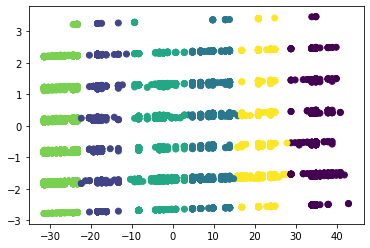

In [102]:
plt.scatter(df_pca[0],df_pca[1], c=cluster_ids)

In [103]:
X_train = sales_means[sales_means['WeekGroup']<9]
X_cv =  sales_means[sales_means['WeekGroup']==10]
X_test = sales_means[sales_means['WeekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['WeekGroup']
del X_cv['WeekGroup']
del X_test['WeekGroup']
# df_pca = df_pca.set_index("itemID")
X_train = X_train.join(df_pca[["cluster"]], on='itemID', how="left")
X_train.cluster = X_train.cluster.fillna(0)
X_test = X_test.join(df_pca[["cluster"]], on='itemID', how="left")
X_test.cluster = X_test.cluster.fillna(0)
X_cv = X_cv.join(df_pca[["cluster"]], on='itemID', how="left")
X_cv.cluster = X_cv.cluster.fillna(0)
X_train.groupby("cluster").count()

,itemID,customerRating,manufacturer,brand,category1,category3,dateFirstSell,soldWeekly,soldMonthly,count_lag_1,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
cluster,,,,,,,,,,,,,,,,,,,,,
0,5974,5974,5974,5974,5974,5974,5974,5974,5974,5974,...,4921,4921,5974,5974,4921,5974,5974,4921,5974,5974
1,2954,2954,2954,2954,2954,2954,2954,2954,2954,2954,...,2095,2095,2954,2954,2095,2954,2954,2095,2954,2954
2,4131,4131,4131,4131,4131,4131,4131,4131,4131,4131,...,2598,2598,4131,4131,2598,4131,4131,2598,4131,4131
3,4794,4794,4794,4794,4794,4794,4794,4794,4794,4794,...,4205,4205,4794,4794,4205,4794,4794,4205,4794,4794
4,9911,9911,9911,9911,9911,9911,9911,9911,9911,9911,...,7986,7986,9911,9911,7986,9911,9911,7986,9911,9911
5,3474,3474,3474,3474,3474,3474,3474,3474,3474,3474,...,2634,2634,3474,3474,2634,3474,3474,2634,3474,3474


In [104]:
del X_train['itemID']
del X_cv['itemID']

In [105]:
y_xgboost_cluster2 = dict()
for cluster in df_pca.cluster.unique(): 
    x_train_category = X_train[X_train.cluster == cluster].drop(columns=["cluster"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.cluster == cluster].drop(columns=["cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.cluster == cluster].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID',"cluster"], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_cluster2[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48991	validation_1-rmse:0.49008
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48502	validation_1-rmse:0.48518
[2]	validation_0-rmse:0.48017	validation_1-rmse:0.48034
[3]	validation_0-rmse:0.47537	validation_1-rmse:0.47554
[4]	validation_0-rmse:0.47063	validation_1-rmse:0.47079
[5]	validation_0-rmse:0.46592	validation_1-rmse:0.46609
[6]	validation_0-rmse:0.46127	validation_1-rmse:0.46143
[7]	validation_0-rmse:0.45666	validation_1-rmse:0.45683
[8]	validation_0-rmse:0.45210	validation_1-rmse:0.45226
[9]	validation_0-rmse:0.44758	validation_1-rmse:0.44775
[10]	validation_0-rmse:0.44311	validation_1-rmse:0.44328
[11]	validation_0-rmse:0.43868	validation_1-rmse:0.43885
[12]	validation_0-rmse:0.43430	validation_1-rmse:0.43447
[13]	validation_0-rmse:0.42996	validation_1-rmse:0.43013
[14]	validation_0-rmse:0.42567	validation_1-rmse:0.42

[141]	validation_0-rmse:0.11941	validation_1-rmse:0.11889
[142]	validation_0-rmse:0.11823	validation_1-rmse:0.11771
[143]	validation_0-rmse:0.11706	validation_1-rmse:0.11653
[144]	validation_0-rmse:0.11590	validation_1-rmse:0.11537
[145]	validation_0-rmse:0.11476	validation_1-rmse:0.11423
[146]	validation_0-rmse:0.11363	validation_1-rmse:0.11309
[147]	validation_0-rmse:0.11250	validation_1-rmse:0.11197
[148]	validation_0-rmse:0.11139	validation_1-rmse:0.11086
[149]	validation_0-rmse:0.11029	validation_1-rmse:0.10975
[150]	validation_0-rmse:0.10920	validation_1-rmse:0.10866
[151]	validation_0-rmse:0.10812	validation_1-rmse:0.10758
[152]	validation_0-rmse:0.10706	validation_1-rmse:0.10651
[153]	validation_0-rmse:0.10600	validation_1-rmse:0.10545
[154]	validation_0-rmse:0.10496	validation_1-rmse:0.10440
[155]	validation_0-rmse:0.10392	validation_1-rmse:0.10337
[156]	validation_0-rmse:0.10290	validation_1-rmse:0.10234
[157]	validation_0-rmse:0.10188	validation_1-rmse:0.10133
[158]	validati

[283]	validation_0-rmse:0.03094	validation_1-rmse:0.03070
[284]	validation_0-rmse:0.03067	validation_1-rmse:0.03044
[285]	validation_0-rmse:0.03041	validation_1-rmse:0.03018
[286]	validation_0-rmse:0.03016	validation_1-rmse:0.02992
[287]	validation_0-rmse:0.02990	validation_1-rmse:0.02968
[288]	validation_0-rmse:0.02965	validation_1-rmse:0.02944
[289]	validation_0-rmse:0.02940	validation_1-rmse:0.02919
[290]	validation_0-rmse:0.02916	validation_1-rmse:0.02895
[291]	validation_0-rmse:0.02891	validation_1-rmse:0.02871
[292]	validation_0-rmse:0.02867	validation_1-rmse:0.02847
[293]	validation_0-rmse:0.02843	validation_1-rmse:0.02823
[294]	validation_0-rmse:0.02820	validation_1-rmse:0.02800
[295]	validation_0-rmse:0.02797	validation_1-rmse:0.02777
[296]	validation_0-rmse:0.02774	validation_1-rmse:0.02755
[297]	validation_0-rmse:0.02751	validation_1-rmse:0.02733
[298]	validation_0-rmse:0.02729	validation_1-rmse:0.02711
[299]	validation_0-rmse:0.02707	validation_1-rmse:0.02689
[300]	validati

[425]	validation_0-rmse:0.01357	validation_1-rmse:0.01392
[426]	validation_0-rmse:0.01353	validation_1-rmse:0.01389
[427]	validation_0-rmse:0.01350	validation_1-rmse:0.01386
[428]	validation_0-rmse:0.01346	validation_1-rmse:0.01383
[429]	validation_0-rmse:0.01343	validation_1-rmse:0.01379
[430]	validation_0-rmse:0.01339	validation_1-rmse:0.01376
[431]	validation_0-rmse:0.01336	validation_1-rmse:0.01373
[432]	validation_0-rmse:0.01333	validation_1-rmse:0.01371
[433]	validation_0-rmse:0.01330	validation_1-rmse:0.01368
[434]	validation_0-rmse:0.01327	validation_1-rmse:0.01365
[435]	validation_0-rmse:0.01324	validation_1-rmse:0.01362
[436]	validation_0-rmse:0.01320	validation_1-rmse:0.01359
[437]	validation_0-rmse:0.01317	validation_1-rmse:0.01356
[438]	validation_0-rmse:0.01315	validation_1-rmse:0.01354
[439]	validation_0-rmse:0.01312	validation_1-rmse:0.01351
[440]	validation_0-rmse:0.01309	validation_1-rmse:0.01349
[441]	validation_0-rmse:0.01306	validation_1-rmse:0.01346
[442]	validati

[567]	validation_0-rmse:0.01168	validation_1-rmse:0.01226
[568]	validation_0-rmse:0.01168	validation_1-rmse:0.01226
[569]	validation_0-rmse:0.01167	validation_1-rmse:0.01226
[570]	validation_0-rmse:0.01167	validation_1-rmse:0.01226
[571]	validation_0-rmse:0.01167	validation_1-rmse:0.01225
[572]	validation_0-rmse:0.01166	validation_1-rmse:0.01225
[573]	validation_0-rmse:0.01166	validation_1-rmse:0.01225
[574]	validation_0-rmse:0.01166	validation_1-rmse:0.01225
[575]	validation_0-rmse:0.01165	validation_1-rmse:0.01224
[576]	validation_0-rmse:0.01165	validation_1-rmse:0.01224
[577]	validation_0-rmse:0.01165	validation_1-rmse:0.01224
[578]	validation_0-rmse:0.01165	validation_1-rmse:0.01224
[579]	validation_0-rmse:0.01164	validation_1-rmse:0.01223
[580]	validation_0-rmse:0.01164	validation_1-rmse:0.01223
[581]	validation_0-rmse:0.01164	validation_1-rmse:0.01223
[582]	validation_0-rmse:0.01163	validation_1-rmse:0.01223
[583]	validation_0-rmse:0.01163	validation_1-rmse:0.01223
[584]	validati

[709]	validation_0-rmse:0.01146	validation_1-rmse:0.01214
[710]	validation_0-rmse:0.01146	validation_1-rmse:0.01214
[711]	validation_0-rmse:0.01146	validation_1-rmse:0.01214
[712]	validation_0-rmse:0.01146	validation_1-rmse:0.01214
[713]	validation_0-rmse:0.01146	validation_1-rmse:0.01214
[714]	validation_0-rmse:0.01146	validation_1-rmse:0.01213
[715]	validation_0-rmse:0.01146	validation_1-rmse:0.01213
[716]	validation_0-rmse:0.01146	validation_1-rmse:0.01213
[717]	validation_0-rmse:0.01146	validation_1-rmse:0.01213
[718]	validation_0-rmse:0.01146	validation_1-rmse:0.01213
[719]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[720]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[721]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[722]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[723]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[724]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[725]	validation_0-rmse:0.01145	validation_1-rmse:0.01213
[726]	validati

[77]	validation_0-rmse:0.22438	validation_1-rmse:0.22584
[78]	validation_0-rmse:0.22216	validation_1-rmse:0.22361
[79]	validation_0-rmse:0.21997	validation_1-rmse:0.22139
[80]	validation_0-rmse:0.21780	validation_1-rmse:0.21933
[81]	validation_0-rmse:0.21565	validation_1-rmse:0.21716
[82]	validation_0-rmse:0.21352	validation_1-rmse:0.21501
[83]	validation_0-rmse:0.21142	validation_1-rmse:0.21300
[84]	validation_0-rmse:0.20932	validation_1-rmse:0.21090
[85]	validation_0-rmse:0.20726	validation_1-rmse:0.20882
[86]	validation_0-rmse:0.20521	validation_1-rmse:0.20687
[87]	validation_0-rmse:0.20319	validation_1-rmse:0.20484
[88]	validation_0-rmse:0.20119	validation_1-rmse:0.20282
[89]	validation_0-rmse:0.19921	validation_1-rmse:0.20083
[90]	validation_0-rmse:0.19725	validation_1-rmse:0.19894
[91]	validation_0-rmse:0.19531	validation_1-rmse:0.19698
[92]	validation_0-rmse:0.19338	validation_1-rmse:0.19512
[93]	validation_0-rmse:0.19148	validation_1-rmse:0.19320
[94]	validation_0-rmse:0.18959	

[219]	validation_0-rmse:0.05840	validation_1-rmse:0.06005
[220]	validation_0-rmse:0.05791	validation_1-rmse:0.05952
[221]	validation_0-rmse:0.05742	validation_1-rmse:0.05901
[222]	validation_0-rmse:0.05694	validation_1-rmse:0.05852
[223]	validation_0-rmse:0.05646	validation_1-rmse:0.05801
[224]	validation_0-rmse:0.05599	validation_1-rmse:0.05752
[225]	validation_0-rmse:0.05552	validation_1-rmse:0.05703
[226]	validation_0-rmse:0.05506	validation_1-rmse:0.05656
[227]	validation_0-rmse:0.05461	validation_1-rmse:0.05607
[228]	validation_0-rmse:0.05416	validation_1-rmse:0.05559
[229]	validation_0-rmse:0.05372	validation_1-rmse:0.05513
[230]	validation_0-rmse:0.05327	validation_1-rmse:0.05464
[231]	validation_0-rmse:0.05284	validation_1-rmse:0.05423
[232]	validation_0-rmse:0.05241	validation_1-rmse:0.05378
[233]	validation_0-rmse:0.05199	validation_1-rmse:0.05329
[234]	validation_0-rmse:0.05157	validation_1-rmse:0.05283
[235]	validation_0-rmse:0.05115	validation_1-rmse:0.05244
[236]	validati

[361]	validation_0-rmse:0.02590	validation_1-rmse:0.02227
[362]	validation_0-rmse:0.02583	validation_1-rmse:0.02217
[363]	validation_0-rmse:0.02577	validation_1-rmse:0.02207
[364]	validation_0-rmse:0.02570	validation_1-rmse:0.02196
[365]	validation_0-rmse:0.02564	validation_1-rmse:0.02185
[366]	validation_0-rmse:0.02557	validation_1-rmse:0.02174
[367]	validation_0-rmse:0.02551	validation_1-rmse:0.02164
[368]	validation_0-rmse:0.02545	validation_1-rmse:0.02153
[369]	validation_0-rmse:0.02539	validation_1-rmse:0.02142
[370]	validation_0-rmse:0.02533	validation_1-rmse:0.02132
[371]	validation_0-rmse:0.02527	validation_1-rmse:0.02123
[372]	validation_0-rmse:0.02521	validation_1-rmse:0.02113
[373]	validation_0-rmse:0.02516	validation_1-rmse:0.02102
[374]	validation_0-rmse:0.02510	validation_1-rmse:0.02093
[375]	validation_0-rmse:0.02504	validation_1-rmse:0.02084
[376]	validation_0-rmse:0.02499	validation_1-rmse:0.02076
[377]	validation_0-rmse:0.02494	validation_1-rmse:0.02069
[378]	validati

[503]	validation_0-rmse:0.02229	validation_1-rmse:0.01536
[504]	validation_0-rmse:0.02228	validation_1-rmse:0.01534
[505]	validation_0-rmse:0.02228	validation_1-rmse:0.01531
[506]	validation_0-rmse:0.02227	validation_1-rmse:0.01529
[507]	validation_0-rmse:0.02227	validation_1-rmse:0.01527
[508]	validation_0-rmse:0.02226	validation_1-rmse:0.01526
[509]	validation_0-rmse:0.02225	validation_1-rmse:0.01524
[510]	validation_0-rmse:0.02225	validation_1-rmse:0.01522
[511]	validation_0-rmse:0.02224	validation_1-rmse:0.01521
[512]	validation_0-rmse:0.02224	validation_1-rmse:0.01519
[513]	validation_0-rmse:0.02223	validation_1-rmse:0.01518
[514]	validation_0-rmse:0.02223	validation_1-rmse:0.01516
[515]	validation_0-rmse:0.02222	validation_1-rmse:0.01514
[516]	validation_0-rmse:0.02222	validation_1-rmse:0.01512
[517]	validation_0-rmse:0.02221	validation_1-rmse:0.01510
[518]	validation_0-rmse:0.02220	validation_1-rmse:0.01509
[519]	validation_0-rmse:0.02220	validation_1-rmse:0.01507
[520]	validati

[645]	validation_0-rmse:0.02183	validation_1-rmse:0.01410
[646]	validation_0-rmse:0.02183	validation_1-rmse:0.01410
[647]	validation_0-rmse:0.02183	validation_1-rmse:0.01409
[648]	validation_0-rmse:0.02182	validation_1-rmse:0.01409
[649]	validation_0-rmse:0.02182	validation_1-rmse:0.01408
[650]	validation_0-rmse:0.02182	validation_1-rmse:0.01407
[651]	validation_0-rmse:0.02182	validation_1-rmse:0.01406
[652]	validation_0-rmse:0.02182	validation_1-rmse:0.01406
[653]	validation_0-rmse:0.02182	validation_1-rmse:0.01405
[654]	validation_0-rmse:0.02181	validation_1-rmse:0.01404
[655]	validation_0-rmse:0.02181	validation_1-rmse:0.01404
[656]	validation_0-rmse:0.02181	validation_1-rmse:0.01403
[657]	validation_0-rmse:0.02181	validation_1-rmse:0.01402
[658]	validation_0-rmse:0.02181	validation_1-rmse:0.01402
[659]	validation_0-rmse:0.02180	validation_1-rmse:0.01402
[660]	validation_0-rmse:0.02180	validation_1-rmse:0.01403
[661]	validation_0-rmse:0.02180	validation_1-rmse:0.01402
[662]	validati

[67]	validation_0-rmse:0.24864	validation_1-rmse:0.24973
[68]	validation_0-rmse:0.24624	validation_1-rmse:0.24731
[69]	validation_0-rmse:0.24387	validation_1-rmse:0.24489
[70]	validation_0-rmse:0.24153	validation_1-rmse:0.24250
[71]	validation_0-rmse:0.23922	validation_1-rmse:0.24016
[72]	validation_0-rmse:0.23692	validation_1-rmse:0.23780
[73]	validation_0-rmse:0.23465	validation_1-rmse:0.23551
[74]	validation_0-rmse:0.23241	validation_1-rmse:0.23324
[75]	validation_0-rmse:0.23018	validation_1-rmse:0.23103
[76]	validation_0-rmse:0.22798	validation_1-rmse:0.22880
[77]	validation_0-rmse:0.22580	validation_1-rmse:0.22659
[78]	validation_0-rmse:0.22365	validation_1-rmse:0.22445
[79]	validation_0-rmse:0.22152	validation_1-rmse:0.22228
[80]	validation_0-rmse:0.21940	validation_1-rmse:0.22015
[81]	validation_0-rmse:0.21731	validation_1-rmse:0.21803
[82]	validation_0-rmse:0.21525	validation_1-rmse:0.21593
[83]	validation_0-rmse:0.21321	validation_1-rmse:0.21382
[84]	validation_0-rmse:0.21118	

[209]	validation_0-rmse:0.07476	validation_1-rmse:0.07067
[210]	validation_0-rmse:0.07429	validation_1-rmse:0.07014
[211]	validation_0-rmse:0.07383	validation_1-rmse:0.06962
[212]	validation_0-rmse:0.07338	validation_1-rmse:0.06920
[213]	validation_0-rmse:0.07293	validation_1-rmse:0.06868
[214]	validation_0-rmse:0.07248	validation_1-rmse:0.06818
[215]	validation_0-rmse:0.07205	validation_1-rmse:0.06778
[216]	validation_0-rmse:0.07162	validation_1-rmse:0.06729
[217]	validation_0-rmse:0.07120	validation_1-rmse:0.06682
[218]	validation_0-rmse:0.07079	validation_1-rmse:0.06634
[219]	validation_0-rmse:0.07037	validation_1-rmse:0.06587
[220]	validation_0-rmse:0.06996	validation_1-rmse:0.06539
[221]	validation_0-rmse:0.06956	validation_1-rmse:0.06496
[222]	validation_0-rmse:0.06917	validation_1-rmse:0.06453
[223]	validation_0-rmse:0.06879	validation_1-rmse:0.06408
[224]	validation_0-rmse:0.06840	validation_1-rmse:0.06361
[225]	validation_0-rmse:0.06802	validation_1-rmse:0.06319
[226]	validati

[351]	validation_0-rmse:0.04736	validation_1-rmse:0.03756
[352]	validation_0-rmse:0.04731	validation_1-rmse:0.03749
[353]	validation_0-rmse:0.04726	validation_1-rmse:0.03742
[354]	validation_0-rmse:0.04722	validation_1-rmse:0.03736
[355]	validation_0-rmse:0.04717	validation_1-rmse:0.03728
[356]	validation_0-rmse:0.04713	validation_1-rmse:0.03721
[357]	validation_0-rmse:0.04708	validation_1-rmse:0.03714
[358]	validation_0-rmse:0.04704	validation_1-rmse:0.03709
[359]	validation_0-rmse:0.04700	validation_1-rmse:0.03702
[360]	validation_0-rmse:0.04696	validation_1-rmse:0.03695
[361]	validation_0-rmse:0.04691	validation_1-rmse:0.03687
[362]	validation_0-rmse:0.04687	validation_1-rmse:0.03682
[363]	validation_0-rmse:0.04684	validation_1-rmse:0.03677
[364]	validation_0-rmse:0.04679	validation_1-rmse:0.03671
[365]	validation_0-rmse:0.04675	validation_1-rmse:0.03664
[366]	validation_0-rmse:0.04671	validation_1-rmse:0.03659
[367]	validation_0-rmse:0.04668	validation_1-rmse:0.03654
[368]	validati

[493]	validation_0-rmse:0.04456	validation_1-rmse:0.03356
[494]	validation_0-rmse:0.04455	validation_1-rmse:0.03355
[495]	validation_0-rmse:0.04455	validation_1-rmse:0.03354
[496]	validation_0-rmse:0.04454	validation_1-rmse:0.03354
[497]	validation_0-rmse:0.04453	validation_1-rmse:0.03354
[498]	validation_0-rmse:0.04453	validation_1-rmse:0.03352
[499]	validation_0-rmse:0.04452	validation_1-rmse:0.03352
[500]	validation_0-rmse:0.04451	validation_1-rmse:0.03351
[501]	validation_0-rmse:0.04450	validation_1-rmse:0.03350
[502]	validation_0-rmse:0.04450	validation_1-rmse:0.03350
[503]	validation_0-rmse:0.04449	validation_1-rmse:0.03350
[504]	validation_0-rmse:0.04448	validation_1-rmse:0.03349
[505]	validation_0-rmse:0.04448	validation_1-rmse:0.03349
[506]	validation_0-rmse:0.04447	validation_1-rmse:0.03349
[507]	validation_0-rmse:0.04446	validation_1-rmse:0.03349
[508]	validation_0-rmse:0.04446	validation_1-rmse:0.03348
[509]	validation_0-rmse:0.04445	validation_1-rmse:0.03346
[510]	validati

[97]	validation_0-rmse:0.18602	validation_1-rmse:0.19081
[98]	validation_0-rmse:0.18437	validation_1-rmse:0.18916
[99]	validation_0-rmse:0.18272	validation_1-rmse:0.18749
[100]	validation_0-rmse:0.18110	validation_1-rmse:0.18589
[101]	validation_0-rmse:0.17950	validation_1-rmse:0.18433
[102]	validation_0-rmse:0.17793	validation_1-rmse:0.18277
[103]	validation_0-rmse:0.17636	validation_1-rmse:0.18121
[104]	validation_0-rmse:0.17481	validation_1-rmse:0.17971
[105]	validation_0-rmse:0.17328	validation_1-rmse:0.17814
[106]	validation_0-rmse:0.17176	validation_1-rmse:0.17663
[107]	validation_0-rmse:0.17026	validation_1-rmse:0.17518
[108]	validation_0-rmse:0.16878	validation_1-rmse:0.17367
[109]	validation_0-rmse:0.16731	validation_1-rmse:0.17219
[110]	validation_0-rmse:0.16585	validation_1-rmse:0.17075
[111]	validation_0-rmse:0.16441	validation_1-rmse:0.16933
[112]	validation_0-rmse:0.16299	validation_1-rmse:0.16788
[113]	validation_0-rmse:0.16160	validation_1-rmse:0.16648
[114]	validation_

[239]	validation_0-rmse:0.07327	validation_1-rmse:0.07877
[240]	validation_0-rmse:0.07302	validation_1-rmse:0.07852
[241]	validation_0-rmse:0.07278	validation_1-rmse:0.07826
[242]	validation_0-rmse:0.07253	validation_1-rmse:0.07801
[243]	validation_0-rmse:0.07229	validation_1-rmse:0.07779
[244]	validation_0-rmse:0.07206	validation_1-rmse:0.07754
[245]	validation_0-rmse:0.07182	validation_1-rmse:0.07731
[246]	validation_0-rmse:0.07160	validation_1-rmse:0.07711
[247]	validation_0-rmse:0.07139	validation_1-rmse:0.07689
[248]	validation_0-rmse:0.07116	validation_1-rmse:0.07666
[249]	validation_0-rmse:0.07095	validation_1-rmse:0.07645
[250]	validation_0-rmse:0.07074	validation_1-rmse:0.07625
[251]	validation_0-rmse:0.07053	validation_1-rmse:0.07605
[252]	validation_0-rmse:0.07032	validation_1-rmse:0.07585
[253]	validation_0-rmse:0.07012	validation_1-rmse:0.07568
[254]	validation_0-rmse:0.06992	validation_1-rmse:0.07547
[255]	validation_0-rmse:0.06973	validation_1-rmse:0.07529
[256]	validati

[381]	validation_0-rmse:0.05967	validation_1-rmse:0.06532
[382]	validation_0-rmse:0.05965	validation_1-rmse:0.06529
[383]	validation_0-rmse:0.05963	validation_1-rmse:0.06527
[384]	validation_0-rmse:0.05960	validation_1-rmse:0.06526
[385]	validation_0-rmse:0.05958	validation_1-rmse:0.06524
[386]	validation_0-rmse:0.05956	validation_1-rmse:0.06523
[387]	validation_0-rmse:0.05954	validation_1-rmse:0.06520
[388]	validation_0-rmse:0.05952	validation_1-rmse:0.06519
[389]	validation_0-rmse:0.05950	validation_1-rmse:0.06517
[390]	validation_0-rmse:0.05948	validation_1-rmse:0.06515
[391]	validation_0-rmse:0.05946	validation_1-rmse:0.06512
[392]	validation_0-rmse:0.05944	validation_1-rmse:0.06510
[393]	validation_0-rmse:0.05942	validation_1-rmse:0.06508
[394]	validation_0-rmse:0.05940	validation_1-rmse:0.06507
[395]	validation_0-rmse:0.05938	validation_1-rmse:0.06505
[396]	validation_0-rmse:0.05936	validation_1-rmse:0.06504
[397]	validation_0-rmse:0.05934	validation_1-rmse:0.06502
[398]	validati

[523]	validation_0-rmse:0.05810	validation_1-rmse:0.06425
[524]	validation_0-rmse:0.05810	validation_1-rmse:0.06425
[525]	validation_0-rmse:0.05809	validation_1-rmse:0.06425
[526]	validation_0-rmse:0.05809	validation_1-rmse:0.06425
[527]	validation_0-rmse:0.05808	validation_1-rmse:0.06424
[528]	validation_0-rmse:0.05808	validation_1-rmse:0.06423
[529]	validation_0-rmse:0.05807	validation_1-rmse:0.06423
[530]	validation_0-rmse:0.05806	validation_1-rmse:0.06423
[531]	validation_0-rmse:0.05806	validation_1-rmse:0.06423
[532]	validation_0-rmse:0.05805	validation_1-rmse:0.06423
[533]	validation_0-rmse:0.05805	validation_1-rmse:0.06422
[534]	validation_0-rmse:0.05804	validation_1-rmse:0.06423
[535]	validation_0-rmse:0.05804	validation_1-rmse:0.06422
[536]	validation_0-rmse:0.05803	validation_1-rmse:0.06422
[537]	validation_0-rmse:0.05803	validation_1-rmse:0.06421
[538]	validation_0-rmse:0.05802	validation_1-rmse:0.06421
[539]	validation_0-rmse:0.05801	validation_1-rmse:0.06421
[540]	validati

[29]	validation_0-rmse:0.36358	validation_1-rmse:0.35969
[30]	validation_0-rmse:0.35996	validation_1-rmse:0.35607
[31]	validation_0-rmse:0.35639	validation_1-rmse:0.35250
[32]	validation_0-rmse:0.35285	validation_1-rmse:0.34896
[33]	validation_0-rmse:0.34935	validation_1-rmse:0.34545
[34]	validation_0-rmse:0.34587	validation_1-rmse:0.34198
[35]	validation_0-rmse:0.34244	validation_1-rmse:0.33855
[36]	validation_0-rmse:0.33904	validation_1-rmse:0.33515
[37]	validation_0-rmse:0.33567	validation_1-rmse:0.33178
[38]	validation_0-rmse:0.33234	validation_1-rmse:0.32845
[39]	validation_0-rmse:0.32904	validation_1-rmse:0.32515
[40]	validation_0-rmse:0.32577	validation_1-rmse:0.32188
[41]	validation_0-rmse:0.32254	validation_1-rmse:0.31865
[42]	validation_0-rmse:0.31933	validation_1-rmse:0.31544
[43]	validation_0-rmse:0.31616	validation_1-rmse:0.31227
[44]	validation_0-rmse:0.31302	validation_1-rmse:0.30913
[45]	validation_0-rmse:0.30992	validation_1-rmse:0.30603
[46]	validation_0-rmse:0.30684	

[172]	validation_0-rmse:0.09019	validation_1-rmse:0.08618
[173]	validation_0-rmse:0.08936	validation_1-rmse:0.08536
[174]	validation_0-rmse:0.08855	validation_1-rmse:0.08455
[175]	validation_0-rmse:0.08774	validation_1-rmse:0.08376
[176]	validation_0-rmse:0.08694	validation_1-rmse:0.08295
[177]	validation_0-rmse:0.08615	validation_1-rmse:0.08216
[178]	validation_0-rmse:0.08537	validation_1-rmse:0.08138
[179]	validation_0-rmse:0.08460	validation_1-rmse:0.08061
[180]	validation_0-rmse:0.08383	validation_1-rmse:0.07984
[181]	validation_0-rmse:0.08307	validation_1-rmse:0.07906
[182]	validation_0-rmse:0.08233	validation_1-rmse:0.07833
[183]	validation_0-rmse:0.08159	validation_1-rmse:0.07757
[184]	validation_0-rmse:0.08086	validation_1-rmse:0.07683
[185]	validation_0-rmse:0.08014	validation_1-rmse:0.07612
[186]	validation_0-rmse:0.07942	validation_1-rmse:0.07542
[187]	validation_0-rmse:0.07871	validation_1-rmse:0.07472
[188]	validation_0-rmse:0.07802	validation_1-rmse:0.07401
[189]	validati

[314]	validation_0-rmse:0.03297	validation_1-rmse:0.03049
[315]	validation_0-rmse:0.03283	validation_1-rmse:0.03038
[316]	validation_0-rmse:0.03270	validation_1-rmse:0.03026
[317]	validation_0-rmse:0.03257	validation_1-rmse:0.03015
[318]	validation_0-rmse:0.03245	validation_1-rmse:0.03004
[319]	validation_0-rmse:0.03232	validation_1-rmse:0.02993
[320]	validation_0-rmse:0.03220	validation_1-rmse:0.02981
[321]	validation_0-rmse:0.03208	validation_1-rmse:0.02969
[322]	validation_0-rmse:0.03196	validation_1-rmse:0.02959
[323]	validation_0-rmse:0.03184	validation_1-rmse:0.02948
[324]	validation_0-rmse:0.03172	validation_1-rmse:0.02938
[325]	validation_0-rmse:0.03161	validation_1-rmse:0.02929
[326]	validation_0-rmse:0.03150	validation_1-rmse:0.02920
[327]	validation_0-rmse:0.03139	validation_1-rmse:0.02911
[328]	validation_0-rmse:0.03128	validation_1-rmse:0.02902
[329]	validation_0-rmse:0.03117	validation_1-rmse:0.02892
[330]	validation_0-rmse:0.03106	validation_1-rmse:0.02884
[331]	validati

[456]	validation_0-rmse:0.02565	validation_1-rmse:0.02505
[457]	validation_0-rmse:0.02563	validation_1-rmse:0.02505
[458]	validation_0-rmse:0.02562	validation_1-rmse:0.02504
[459]	validation_0-rmse:0.02561	validation_1-rmse:0.02504
[460]	validation_0-rmse:0.02560	validation_1-rmse:0.02505
[461]	validation_0-rmse:0.02559	validation_1-rmse:0.02504
[462]	validation_0-rmse:0.02557	validation_1-rmse:0.02503
[463]	validation_0-rmse:0.02556	validation_1-rmse:0.02503
[464]	validation_0-rmse:0.02555	validation_1-rmse:0.02502
[465]	validation_0-rmse:0.02553	validation_1-rmse:0.02502
[466]	validation_0-rmse:0.02552	validation_1-rmse:0.02502
[467]	validation_0-rmse:0.02551	validation_1-rmse:0.02502
[468]	validation_0-rmse:0.02550	validation_1-rmse:0.02502
[469]	validation_0-rmse:0.02549	validation_1-rmse:0.02501
[470]	validation_0-rmse:0.02548	validation_1-rmse:0.02501
[471]	validation_0-rmse:0.02547	validation_1-rmse:0.02501
[472]	validation_0-rmse:0.02546	validation_1-rmse:0.02502
[473]	validati

[82]	validation_0-rmse:0.21643	validation_1-rmse:0.21588
[83]	validation_0-rmse:0.21427	validation_1-rmse:0.21372
[84]	validation_0-rmse:0.21213	validation_1-rmse:0.21158
[85]	validation_0-rmse:0.21001	validation_1-rmse:0.20947
[86]	validation_0-rmse:0.20792	validation_1-rmse:0.20737
[87]	validation_0-rmse:0.20584	validation_1-rmse:0.20529
[88]	validation_0-rmse:0.20378	validation_1-rmse:0.20324
[89]	validation_0-rmse:0.20175	validation_1-rmse:0.20120
[90]	validation_0-rmse:0.19973	validation_1-rmse:0.19919
[91]	validation_0-rmse:0.19774	validation_1-rmse:0.19720
[92]	validation_0-rmse:0.19576	validation_1-rmse:0.19522
[93]	validation_0-rmse:0.19381	validation_1-rmse:0.19327
[94]	validation_0-rmse:0.19187	validation_1-rmse:0.19133
[95]	validation_0-rmse:0.18996	validation_1-rmse:0.18942
[96]	validation_0-rmse:0.18806	validation_1-rmse:0.18752
[97]	validation_0-rmse:0.18618	validation_1-rmse:0.18565
[98]	validation_0-rmse:0.18432	validation_1-rmse:0.18379
[99]	validation_0-rmse:0.18248	

[224]	validation_0-rmse:0.05233	validation_1-rmse:0.05192
[225]	validation_0-rmse:0.05182	validation_1-rmse:0.05140
[226]	validation_0-rmse:0.05131	validation_1-rmse:0.05089
[227]	validation_0-rmse:0.05080	validation_1-rmse:0.05039
[228]	validation_0-rmse:0.05030	validation_1-rmse:0.04990
[229]	validation_0-rmse:0.04981	validation_1-rmse:0.04942
[230]	validation_0-rmse:0.04932	validation_1-rmse:0.04893
[231]	validation_0-rmse:0.04883	validation_1-rmse:0.04844
[232]	validation_0-rmse:0.04835	validation_1-rmse:0.04796
[233]	validation_0-rmse:0.04788	validation_1-rmse:0.04750
[234]	validation_0-rmse:0.04741	validation_1-rmse:0.04703
[235]	validation_0-rmse:0.04694	validation_1-rmse:0.04657
[236]	validation_0-rmse:0.04648	validation_1-rmse:0.04611
[237]	validation_0-rmse:0.04603	validation_1-rmse:0.04566
[238]	validation_0-rmse:0.04558	validation_1-rmse:0.04521
[239]	validation_0-rmse:0.04513	validation_1-rmse:0.04477
[240]	validation_0-rmse:0.04469	validation_1-rmse:0.04433
[241]	validati

[366]	validation_0-rmse:0.01392	validation_1-rmse:0.01453
[367]	validation_0-rmse:0.01380	validation_1-rmse:0.01443
[368]	validation_0-rmse:0.01369	validation_1-rmse:0.01433
[369]	validation_0-rmse:0.01358	validation_1-rmse:0.01422
[370]	validation_0-rmse:0.01347	validation_1-rmse:0.01412
[371]	validation_0-rmse:0.01337	validation_1-rmse:0.01402
[372]	validation_0-rmse:0.01326	validation_1-rmse:0.01393
[373]	validation_0-rmse:0.01316	validation_1-rmse:0.01383
[374]	validation_0-rmse:0.01305	validation_1-rmse:0.01374
[375]	validation_0-rmse:0.01295	validation_1-rmse:0.01365
[376]	validation_0-rmse:0.01285	validation_1-rmse:0.01355
[377]	validation_0-rmse:0.01275	validation_1-rmse:0.01347
[378]	validation_0-rmse:0.01265	validation_1-rmse:0.01338
[379]	validation_0-rmse:0.01256	validation_1-rmse:0.01329
[380]	validation_0-rmse:0.01246	validation_1-rmse:0.01320
[381]	validation_0-rmse:0.01237	validation_1-rmse:0.01312
[382]	validation_0-rmse:0.01227	validation_1-rmse:0.01303
[383]	validati

[508]	validation_0-rmse:0.00675	validation_1-rmse:0.00845
[509]	validation_0-rmse:0.00674	validation_1-rmse:0.00844
[510]	validation_0-rmse:0.00673	validation_1-rmse:0.00843
[511]	validation_0-rmse:0.00671	validation_1-rmse:0.00842
[512]	validation_0-rmse:0.00670	validation_1-rmse:0.00841
[513]	validation_0-rmse:0.00669	validation_1-rmse:0.00840
[514]	validation_0-rmse:0.00667	validation_1-rmse:0.00839
[515]	validation_0-rmse:0.00666	validation_1-rmse:0.00838
[516]	validation_0-rmse:0.00665	validation_1-rmse:0.00837
[517]	validation_0-rmse:0.00664	validation_1-rmse:0.00836
[518]	validation_0-rmse:0.00663	validation_1-rmse:0.00835
[519]	validation_0-rmse:0.00661	validation_1-rmse:0.00835
[520]	validation_0-rmse:0.00660	validation_1-rmse:0.00834
[521]	validation_0-rmse:0.00659	validation_1-rmse:0.00833
[522]	validation_0-rmse:0.00658	validation_1-rmse:0.00833
[523]	validation_0-rmse:0.00657	validation_1-rmse:0.00832
[524]	validation_0-rmse:0.00656	validation_1-rmse:0.00831
[525]	validati

[650]	validation_0-rmse:0.00603	validation_1-rmse:0.00797
[651]	validation_0-rmse:0.00603	validation_1-rmse:0.00797
[652]	validation_0-rmse:0.00603	validation_1-rmse:0.00797
[653]	validation_0-rmse:0.00603	validation_1-rmse:0.00797
[654]	validation_0-rmse:0.00603	validation_1-rmse:0.00797
[655]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[656]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[657]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[658]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[659]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[660]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[661]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[662]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[663]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[664]	validation_0-rmse:0.00602	validation_1-rmse:0.00797
[665]	validation_0-rmse:0.00601	validation_1-rmse:0.00797
[666]	validation_0-rmse:0.00601	validation_1-rmse:0.00796
[667]	validati

In [106]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')
print(f'XGBoost by monthly: {evaluate_result(y, y_xgboost_mon):.2f}')
print(f'XGBoost by cluster: {evaluate_result(y, y_xgboost_cluster):.2f}')
print(f'XGBoost by cluster2: {evaluate_result(y, y_xgboost_cluster2):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27
XGBoost by monthly: 790516.54
XGBoost by cluster: 749835.25
XGBoost by cluster2: 631473.66


4. by category1

In [109]:
X_train = sales_means[sales_means['WeekGroup']<9]
X_cv =  sales_means[sales_means['WeekGroup']==10]
X_test = sales_means[sales_means['WeekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['WeekGroup']
del X_cv['WeekGroup']
del X_test['WeekGroup']
del X_train['itemID']
del X_cv['itemID']

In [122]:
y_xgboost_category1 = dict()
for cat in X_train.category1.unique(): 
    x_train_category = X_train[X_train.category1 == cat]#.drop(columns=["cluster"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.category1 == cat]#.drop(columns=["cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.category1 == cat].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID'], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_category1[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.49071	validation_1-rmse:0.49149
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48581	validation_1-rmse:0.48658
[2]	validation_0-rmse:0.48095	validation_1-rmse:0.48173
[3]	validation_0-rmse:0.47615	validation_1-rmse:0.47692
[4]	validation_0-rmse:0.47139	validation_1-rmse:0.47217
[5]	validation_0-rmse:0.46668	validation_1-rmse:0.46746
[6]	validation_0-rmse:0.46202	validation_1-rmse:0.46279
[7]	validation_0-rmse:0.45741	validation_1-rmse:0.45818
[8]	validation_0-rmse:0.45283	validation_1-rmse:0.45361
[9]	validation_0-rmse:0.44831	validation_1-rmse:0.44908
[10]	validation_0-rmse:0.44383	validation_1-rmse:0.44460
[11]	validation_0-rmse:0.43940	validation_1-rmse:0.44017
[12]	validation_0-rmse:0.43501	validation_1-rmse:0.43578
[13]	validation_0-rmse:0.43066	validation_1-rmse:0.43143
[14]	validation_0-rmse:0.42636	validation_1-rmse:0.42

[141]	validation_0-rmse:0.11957	validation_1-rmse:0.11970
[142]	validation_0-rmse:0.11839	validation_1-rmse:0.11851
[143]	validation_0-rmse:0.11722	validation_1-rmse:0.11733
[144]	validation_0-rmse:0.11606	validation_1-rmse:0.11617
[145]	validation_0-rmse:0.11491	validation_1-rmse:0.11501
[146]	validation_0-rmse:0.11377	validation_1-rmse:0.11386
[147]	validation_0-rmse:0.11265	validation_1-rmse:0.11273
[148]	validation_0-rmse:0.11153	validation_1-rmse:0.11161
[149]	validation_0-rmse:0.11043	validation_1-rmse:0.11050
[150]	validation_0-rmse:0.10934	validation_1-rmse:0.10940
[151]	validation_0-rmse:0.10826	validation_1-rmse:0.10831
[152]	validation_0-rmse:0.10719	validation_1-rmse:0.10724
[153]	validation_0-rmse:0.10613	validation_1-rmse:0.10617
[154]	validation_0-rmse:0.10509	validation_1-rmse:0.10511
[155]	validation_0-rmse:0.10405	validation_1-rmse:0.10407
[156]	validation_0-rmse:0.10303	validation_1-rmse:0.10303
[157]	validation_0-rmse:0.10201	validation_1-rmse:0.10200
[158]	validati

[283]	validation_0-rmse:0.03087	validation_1-rmse:0.02998
[284]	validation_0-rmse:0.03061	validation_1-rmse:0.02971
[285]	validation_0-rmse:0.03035	validation_1-rmse:0.02944
[286]	validation_0-rmse:0.03009	validation_1-rmse:0.02917
[287]	validation_0-rmse:0.02983	validation_1-rmse:0.02890
[288]	validation_0-rmse:0.02958	validation_1-rmse:0.02864
[289]	validation_0-rmse:0.02933	validation_1-rmse:0.02839
[290]	validation_0-rmse:0.02908	validation_1-rmse:0.02814
[291]	validation_0-rmse:0.02884	validation_1-rmse:0.02789
[292]	validation_0-rmse:0.02859	validation_1-rmse:0.02764
[293]	validation_0-rmse:0.02836	validation_1-rmse:0.02739
[294]	validation_0-rmse:0.02812	validation_1-rmse:0.02715
[295]	validation_0-rmse:0.02789	validation_1-rmse:0.02691
[296]	validation_0-rmse:0.02766	validation_1-rmse:0.02668
[297]	validation_0-rmse:0.02743	validation_1-rmse:0.02644
[298]	validation_0-rmse:0.02720	validation_1-rmse:0.02621
[299]	validation_0-rmse:0.02698	validation_1-rmse:0.02598
[300]	validati

[425]	validation_0-rmse:0.01334	validation_1-rmse:0.01158
[426]	validation_0-rmse:0.01330	validation_1-rmse:0.01154
[427]	validation_0-rmse:0.01327	validation_1-rmse:0.01150
[428]	validation_0-rmse:0.01323	validation_1-rmse:0.01146
[429]	validation_0-rmse:0.01320	validation_1-rmse:0.01142
[430]	validation_0-rmse:0.01316	validation_1-rmse:0.01138
[431]	validation_0-rmse:0.01313	validation_1-rmse:0.01135
[432]	validation_0-rmse:0.01310	validation_1-rmse:0.01131
[433]	validation_0-rmse:0.01307	validation_1-rmse:0.01128
[434]	validation_0-rmse:0.01303	validation_1-rmse:0.01125
[435]	validation_0-rmse:0.01300	validation_1-rmse:0.01121
[436]	validation_0-rmse:0.01297	validation_1-rmse:0.01117
[437]	validation_0-rmse:0.01294	validation_1-rmse:0.01114
[438]	validation_0-rmse:0.01291	validation_1-rmse:0.01111
[439]	validation_0-rmse:0.01288	validation_1-rmse:0.01107
[440]	validation_0-rmse:0.01286	validation_1-rmse:0.01104
[441]	validation_0-rmse:0.01283	validation_1-rmse:0.01101
[442]	validati

[567]	validation_0-rmse:0.01140	validation_1-rmse:0.00951
[568]	validation_0-rmse:0.01139	validation_1-rmse:0.00951
[569]	validation_0-rmse:0.01139	validation_1-rmse:0.00950
[570]	validation_0-rmse:0.01139	validation_1-rmse:0.00950
[571]	validation_0-rmse:0.01138	validation_1-rmse:0.00950
[572]	validation_0-rmse:0.01138	validation_1-rmse:0.00950
[573]	validation_0-rmse:0.01138	validation_1-rmse:0.00950
[574]	validation_0-rmse:0.01137	validation_1-rmse:0.00949
[575]	validation_0-rmse:0.01137	validation_1-rmse:0.00949
[576]	validation_0-rmse:0.01137	validation_1-rmse:0.00949
[577]	validation_0-rmse:0.01136	validation_1-rmse:0.00949
[578]	validation_0-rmse:0.01136	validation_1-rmse:0.00949
[579]	validation_0-rmse:0.01136	validation_1-rmse:0.00948
[580]	validation_0-rmse:0.01136	validation_1-rmse:0.00948
[581]	validation_0-rmse:0.01135	validation_1-rmse:0.00948
[582]	validation_0-rmse:0.01135	validation_1-rmse:0.00948
[583]	validation_0-rmse:0.01135	validation_1-rmse:0.00947
[584]	validati

[20]	validation_0-rmse:0.39773	validation_1-rmse:0.39711
[21]	validation_0-rmse:0.39376	validation_1-rmse:0.39314
[22]	validation_0-rmse:0.38983	validation_1-rmse:0.38920
[23]	validation_0-rmse:0.38594	validation_1-rmse:0.38529
[24]	validation_0-rmse:0.38209	validation_1-rmse:0.38143
[25]	validation_0-rmse:0.37828	validation_1-rmse:0.37762
[26]	validation_0-rmse:0.37450	validation_1-rmse:0.37383
[27]	validation_0-rmse:0.37076	validation_1-rmse:0.37008
[28]	validation_0-rmse:0.36706	validation_1-rmse:0.36637
[29]	validation_0-rmse:0.36340	validation_1-rmse:0.36270
[30]	validation_0-rmse:0.35977	validation_1-rmse:0.35906
[31]	validation_0-rmse:0.35618	validation_1-rmse:0.35546
[32]	validation_0-rmse:0.35263	validation_1-rmse:0.35190
[33]	validation_0-rmse:0.34911	validation_1-rmse:0.34837
[34]	validation_0-rmse:0.34562	validation_1-rmse:0.34488
[35]	validation_0-rmse:0.34218	validation_1-rmse:0.34142
[36]	validation_0-rmse:0.33876	validation_1-rmse:0.33800
[37]	validation_0-rmse:0.33538	

[163]	validation_0-rmse:0.09558	validation_1-rmse:0.09492
[164]	validation_0-rmse:0.09464	validation_1-rmse:0.09400
[165]	validation_0-rmse:0.09372	validation_1-rmse:0.09308
[166]	validation_0-rmse:0.09280	validation_1-rmse:0.09222
[167]	validation_0-rmse:0.09190	validation_1-rmse:0.09133
[168]	validation_0-rmse:0.09100	validation_1-rmse:0.09045
[169]	validation_0-rmse:0.09011	validation_1-rmse:0.08955
[170]	validation_0-rmse:0.08923	validation_1-rmse:0.08868
[171]	validation_0-rmse:0.08836	validation_1-rmse:0.08786
[172]	validation_0-rmse:0.08750	validation_1-rmse:0.08701
[173]	validation_0-rmse:0.08665	validation_1-rmse:0.08621
[174]	validation_0-rmse:0.08581	validation_1-rmse:0.08536
[175]	validation_0-rmse:0.08497	validation_1-rmse:0.08453
[176]	validation_0-rmse:0.08414	validation_1-rmse:0.08372
[177]	validation_0-rmse:0.08332	validation_1-rmse:0.08291
[178]	validation_0-rmse:0.08252	validation_1-rmse:0.08215
[179]	validation_0-rmse:0.08171	validation_1-rmse:0.08137
[180]	validati

[305]	validation_0-rmse:0.02635	validation_1-rmse:0.02781
[306]	validation_0-rmse:0.02615	validation_1-rmse:0.02765
[307]	validation_0-rmse:0.02596	validation_1-rmse:0.02747
[308]	validation_0-rmse:0.02576	validation_1-rmse:0.02729
[309]	validation_0-rmse:0.02557	validation_1-rmse:0.02710
[310]	validation_0-rmse:0.02539	validation_1-rmse:0.02692
[311]	validation_0-rmse:0.02520	validation_1-rmse:0.02674
[312]	validation_0-rmse:0.02502	validation_1-rmse:0.02656
[313]	validation_0-rmse:0.02484	validation_1-rmse:0.02638
[314]	validation_0-rmse:0.02466	validation_1-rmse:0.02620
[315]	validation_0-rmse:0.02448	validation_1-rmse:0.02601
[316]	validation_0-rmse:0.02431	validation_1-rmse:0.02584
[317]	validation_0-rmse:0.02413	validation_1-rmse:0.02570
[318]	validation_0-rmse:0.02396	validation_1-rmse:0.02553
[319]	validation_0-rmse:0.02380	validation_1-rmse:0.02539
[320]	validation_0-rmse:0.02363	validation_1-rmse:0.02523
[321]	validation_0-rmse:0.02347	validation_1-rmse:0.02510
[322]	validati

[447]	validation_0-rmse:0.01402	validation_1-rmse:0.01579
[448]	validation_0-rmse:0.01400	validation_1-rmse:0.01576
[449]	validation_0-rmse:0.01397	validation_1-rmse:0.01573
[450]	validation_0-rmse:0.01395	validation_1-rmse:0.01570
[451]	validation_0-rmse:0.01393	validation_1-rmse:0.01568
[452]	validation_0-rmse:0.01391	validation_1-rmse:0.01565
[453]	validation_0-rmse:0.01388	validation_1-rmse:0.01564
[454]	validation_0-rmse:0.01386	validation_1-rmse:0.01562
[455]	validation_0-rmse:0.01384	validation_1-rmse:0.01559
[456]	validation_0-rmse:0.01382	validation_1-rmse:0.01556
[457]	validation_0-rmse:0.01380	validation_1-rmse:0.01554
[458]	validation_0-rmse:0.01378	validation_1-rmse:0.01552
[459]	validation_0-rmse:0.01376	validation_1-rmse:0.01551
[460]	validation_0-rmse:0.01374	validation_1-rmse:0.01549
[461]	validation_0-rmse:0.01372	validation_1-rmse:0.01547
[462]	validation_0-rmse:0.01370	validation_1-rmse:0.01546
[463]	validation_0-rmse:0.01368	validation_1-rmse:0.01544
[464]	validati

[589]	validation_0-rmse:0.01270	validation_1-rmse:0.01429
[590]	validation_0-rmse:0.01270	validation_1-rmse:0.01429
[591]	validation_0-rmse:0.01270	validation_1-rmse:0.01429
[592]	validation_0-rmse:0.01269	validation_1-rmse:0.01429
[593]	validation_0-rmse:0.01269	validation_1-rmse:0.01428
[594]	validation_0-rmse:0.01269	validation_1-rmse:0.01428
[595]	validation_0-rmse:0.01269	validation_1-rmse:0.01427
[596]	validation_0-rmse:0.01268	validation_1-rmse:0.01426
[597]	validation_0-rmse:0.01268	validation_1-rmse:0.01426
[598]	validation_0-rmse:0.01268	validation_1-rmse:0.01426
[599]	validation_0-rmse:0.01268	validation_1-rmse:0.01425
[600]	validation_0-rmse:0.01267	validation_1-rmse:0.01426
[601]	validation_0-rmse:0.01267	validation_1-rmse:0.01425
[602]	validation_0-rmse:0.01267	validation_1-rmse:0.01425
[603]	validation_0-rmse:0.01266	validation_1-rmse:0.01424
[604]	validation_0-rmse:0.01266	validation_1-rmse:0.01424
[605]	validation_0-rmse:0.01266	validation_1-rmse:0.01423
[606]	validati

[731]	validation_0-rmse:0.01244	validation_1-rmse:0.01404
[732]	validation_0-rmse:0.01244	validation_1-rmse:0.01404
[733]	validation_0-rmse:0.01244	validation_1-rmse:0.01404
[734]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[735]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[736]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[737]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[738]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[739]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[740]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[741]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[742]	validation_0-rmse:0.01243	validation_1-rmse:0.01404
[743]	validation_0-rmse:0.01242	validation_1-rmse:0.01404
[744]	validation_0-rmse:0.01242	validation_1-rmse:0.01404
[745]	validation_0-rmse:0.01242	validation_1-rmse:0.01404
[746]	validation_0-rmse:0.01242	validation_1-rmse:0.01404
[747]	validation_0-rmse:0.01242	validation_1-rmse:0.01404
[748]	validati

[100]	validation_0-rmse:0.18244	validation_1-rmse:0.17909
[101]	validation_0-rmse:0.18072	validation_1-rmse:0.17733
[102]	validation_0-rmse:0.17900	validation_1-rmse:0.17558
[103]	validation_0-rmse:0.17732	validation_1-rmse:0.17386
[104]	validation_0-rmse:0.17564	validation_1-rmse:0.17215
[105]	validation_0-rmse:0.17398	validation_1-rmse:0.17045
[106]	validation_0-rmse:0.17234	validation_1-rmse:0.16877
[107]	validation_0-rmse:0.17071	validation_1-rmse:0.16711
[108]	validation_0-rmse:0.16909	validation_1-rmse:0.16545
[109]	validation_0-rmse:0.16749	validation_1-rmse:0.16381
[110]	validation_0-rmse:0.16592	validation_1-rmse:0.16220
[111]	validation_0-rmse:0.16438	validation_1-rmse:0.16062
[112]	validation_0-rmse:0.16285	validation_1-rmse:0.15905
[113]	validation_0-rmse:0.16131	validation_1-rmse:0.15747
[114]	validation_0-rmse:0.15979	validation_1-rmse:0.15591
[115]	validation_0-rmse:0.15831	validation_1-rmse:0.15438
[116]	validation_0-rmse:0.15683	validation_1-rmse:0.15287
[117]	validati

[242]	validation_0-rmse:0.05883	validation_1-rmse:0.04657
[243]	validation_0-rmse:0.05852	validation_1-rmse:0.04617
[244]	validation_0-rmse:0.05821	validation_1-rmse:0.04579
[245]	validation_0-rmse:0.05792	validation_1-rmse:0.04541
[246]	validation_0-rmse:0.05763	validation_1-rmse:0.04504
[247]	validation_0-rmse:0.05735	validation_1-rmse:0.04468
[248]	validation_0-rmse:0.05706	validation_1-rmse:0.04430
[249]	validation_0-rmse:0.05677	validation_1-rmse:0.04393
[250]	validation_0-rmse:0.05649	validation_1-rmse:0.04356
[251]	validation_0-rmse:0.05622	validation_1-rmse:0.04320
[252]	validation_0-rmse:0.05595	validation_1-rmse:0.04285
[253]	validation_0-rmse:0.05567	validation_1-rmse:0.04249
[254]	validation_0-rmse:0.05541	validation_1-rmse:0.04214
[255]	validation_0-rmse:0.05515	validation_1-rmse:0.04179
[256]	validation_0-rmse:0.05488	validation_1-rmse:0.04143
[257]	validation_0-rmse:0.05463	validation_1-rmse:0.04109
[258]	validation_0-rmse:0.05438	validation_1-rmse:0.04076
[259]	validati

[384]	validation_0-rmse:0.04170	validation_1-rmse:0.02070
[385]	validation_0-rmse:0.04168	validation_1-rmse:0.02064
[386]	validation_0-rmse:0.04165	validation_1-rmse:0.02059
[387]	validation_0-rmse:0.04163	validation_1-rmse:0.02055
[388]	validation_0-rmse:0.04161	validation_1-rmse:0.02049
[389]	validation_0-rmse:0.04158	validation_1-rmse:0.02044
[390]	validation_0-rmse:0.04156	validation_1-rmse:0.02040
[391]	validation_0-rmse:0.04154	validation_1-rmse:0.02035
[392]	validation_0-rmse:0.04152	validation_1-rmse:0.02031
[393]	validation_0-rmse:0.04149	validation_1-rmse:0.02025
[394]	validation_0-rmse:0.04147	validation_1-rmse:0.02021
[395]	validation_0-rmse:0.04145	validation_1-rmse:0.02017
[396]	validation_0-rmse:0.04143	validation_1-rmse:0.02012
[397]	validation_0-rmse:0.04141	validation_1-rmse:0.02008
[398]	validation_0-rmse:0.04139	validation_1-rmse:0.02004
[399]	validation_0-rmse:0.04138	validation_1-rmse:0.02000
[400]	validation_0-rmse:0.04136	validation_1-rmse:0.01997
[401]	validati

[526]	validation_0-rmse:0.04045	validation_1-rmse:0.01791
[527]	validation_0-rmse:0.04045	validation_1-rmse:0.01791
[528]	validation_0-rmse:0.04045	validation_1-rmse:0.01790
[529]	validation_0-rmse:0.04045	validation_1-rmse:0.01790
[530]	validation_0-rmse:0.04045	validation_1-rmse:0.01790
[531]	validation_0-rmse:0.04045	validation_1-rmse:0.01790
[532]	validation_0-rmse:0.04045	validation_1-rmse:0.01790
[533]	validation_0-rmse:0.04045	validation_1-rmse:0.01789
[534]	validation_0-rmse:0.04045	validation_1-rmse:0.01789
[535]	validation_0-rmse:0.04044	validation_1-rmse:0.01789
[536]	validation_0-rmse:0.04044	validation_1-rmse:0.01788
[537]	validation_0-rmse:0.04044	validation_1-rmse:0.01788
[538]	validation_0-rmse:0.04044	validation_1-rmse:0.01787
[539]	validation_0-rmse:0.04044	validation_1-rmse:0.01787
[540]	validation_0-rmse:0.04043	validation_1-rmse:0.01786
[541]	validation_0-rmse:0.04043	validation_1-rmse:0.01786
[542]	validation_0-rmse:0.04043	validation_1-rmse:0.01786
[543]	validati

[668]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[669]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[670]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[671]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[672]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[673]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[674]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[675]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[676]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[677]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[678]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[679]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[680]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[681]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[682]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
[683]	validation_0-rmse:0.04038	validation_1-rmse:0.01772
Stopping. Best iteration:
[673]	validation_0-rmse:0.04038	validation_1-r

[123]	validation_0-rmse:0.14735	validation_1-rmse:0.14703
[124]	validation_0-rmse:0.14604	validation_1-rmse:0.14565
[125]	validation_0-rmse:0.14475	validation_1-rmse:0.14429
[126]	validation_0-rmse:0.14348	validation_1-rmse:0.14296
[127]	validation_0-rmse:0.14222	validation_1-rmse:0.14163
[128]	validation_0-rmse:0.14097	validation_1-rmse:0.14032
[129]	validation_0-rmse:0.13974	validation_1-rmse:0.13905
[130]	validation_0-rmse:0.13852	validation_1-rmse:0.13778
[131]	validation_0-rmse:0.13732	validation_1-rmse:0.13652
[132]	validation_0-rmse:0.13613	validation_1-rmse:0.13526
[133]	validation_0-rmse:0.13495	validation_1-rmse:0.13403
[134]	validation_0-rmse:0.13379	validation_1-rmse:0.13277
[135]	validation_0-rmse:0.13264	validation_1-rmse:0.13158
[136]	validation_0-rmse:0.13151	validation_1-rmse:0.13040
[137]	validation_0-rmse:0.13038	validation_1-rmse:0.12919
[138]	validation_0-rmse:0.12927	validation_1-rmse:0.12806
[139]	validation_0-rmse:0.12818	validation_1-rmse:0.12691
[140]	validati

[265]	validation_0-rmse:0.05914	validation_1-rmse:0.05080
[266]	validation_0-rmse:0.05895	validation_1-rmse:0.05055
[267]	validation_0-rmse:0.05876	validation_1-rmse:0.05030
[268]	validation_0-rmse:0.05856	validation_1-rmse:0.05004
[269]	validation_0-rmse:0.05838	validation_1-rmse:0.04979
[270]	validation_0-rmse:0.05820	validation_1-rmse:0.04958
[271]	validation_0-rmse:0.05802	validation_1-rmse:0.04938
[272]	validation_0-rmse:0.05785	validation_1-rmse:0.04912
[273]	validation_0-rmse:0.05768	validation_1-rmse:0.04888
[274]	validation_0-rmse:0.05750	validation_1-rmse:0.04868
[275]	validation_0-rmse:0.05734	validation_1-rmse:0.04846
[276]	validation_0-rmse:0.05717	validation_1-rmse:0.04824
[277]	validation_0-rmse:0.05701	validation_1-rmse:0.04802
[278]	validation_0-rmse:0.05685	validation_1-rmse:0.04781
[279]	validation_0-rmse:0.05669	validation_1-rmse:0.04763
[280]	validation_0-rmse:0.05654	validation_1-rmse:0.04742
[281]	validation_0-rmse:0.05638	validation_1-rmse:0.04719
[282]	validati

[407]	validation_0-rmse:0.04854	validation_1-rmse:0.03603
[408]	validation_0-rmse:0.04852	validation_1-rmse:0.03602
[409]	validation_0-rmse:0.04850	validation_1-rmse:0.03599
[410]	validation_0-rmse:0.04849	validation_1-rmse:0.03597
[411]	validation_0-rmse:0.04847	validation_1-rmse:0.03594
[412]	validation_0-rmse:0.04845	validation_1-rmse:0.03592
[413]	validation_0-rmse:0.04843	validation_1-rmse:0.03588
[414]	validation_0-rmse:0.04841	validation_1-rmse:0.03586
[415]	validation_0-rmse:0.04840	validation_1-rmse:0.03583
[416]	validation_0-rmse:0.04838	validation_1-rmse:0.03580
[417]	validation_0-rmse:0.04837	validation_1-rmse:0.03578
[418]	validation_0-rmse:0.04835	validation_1-rmse:0.03574
[419]	validation_0-rmse:0.04833	validation_1-rmse:0.03572
[420]	validation_0-rmse:0.04832	validation_1-rmse:0.03569
[421]	validation_0-rmse:0.04830	validation_1-rmse:0.03567
[422]	validation_0-rmse:0.04828	validation_1-rmse:0.03565
[423]	validation_0-rmse:0.04827	validation_1-rmse:0.03563
[424]	validati

[549]	validation_0-rmse:0.04718	validation_1-rmse:0.03435
[550]	validation_0-rmse:0.04718	validation_1-rmse:0.03436
[551]	validation_0-rmse:0.04717	validation_1-rmse:0.03435
[552]	validation_0-rmse:0.04717	validation_1-rmse:0.03435
[553]	validation_0-rmse:0.04716	validation_1-rmse:0.03435
[554]	validation_0-rmse:0.04716	validation_1-rmse:0.03434
[555]	validation_0-rmse:0.04715	validation_1-rmse:0.03434
[556]	validation_0-rmse:0.04714	validation_1-rmse:0.03432
[557]	validation_0-rmse:0.04714	validation_1-rmse:0.03433
[558]	validation_0-rmse:0.04713	validation_1-rmse:0.03432
[559]	validation_0-rmse:0.04713	validation_1-rmse:0.03432
[560]	validation_0-rmse:0.04712	validation_1-rmse:0.03431
[561]	validation_0-rmse:0.04712	validation_1-rmse:0.03431
[562]	validation_0-rmse:0.04711	validation_1-rmse:0.03431
[563]	validation_0-rmse:0.04711	validation_1-rmse:0.03431
[564]	validation_0-rmse:0.04710	validation_1-rmse:0.03431
[565]	validation_0-rmse:0.04710	validation_1-rmse:0.03432
[566]	validati

[62]	validation_0-rmse:0.25629	validation_1-rmse:0.25737
[63]	validation_0-rmse:0.25387	validation_1-rmse:0.25501
[64]	validation_0-rmse:0.25148	validation_1-rmse:0.25262
[65]	validation_0-rmse:0.24911	validation_1-rmse:0.25034
[66]	validation_0-rmse:0.24676	validation_1-rmse:0.24799
[67]	validation_0-rmse:0.24444	validation_1-rmse:0.24574
[68]	validation_0-rmse:0.24214	validation_1-rmse:0.24339
[69]	validation_0-rmse:0.23987	validation_1-rmse:0.24113
[70]	validation_0-rmse:0.23763	validation_1-rmse:0.23889
[71]	validation_0-rmse:0.23541	validation_1-rmse:0.23675
[72]	validation_0-rmse:0.23321	validation_1-rmse:0.23461
[73]	validation_0-rmse:0.23102	validation_1-rmse:0.23242
[74]	validation_0-rmse:0.22888	validation_1-rmse:0.23032
[75]	validation_0-rmse:0.22675	validation_1-rmse:0.22820
[76]	validation_0-rmse:0.22464	validation_1-rmse:0.22618
[77]	validation_0-rmse:0.22257	validation_1-rmse:0.22408
[78]	validation_0-rmse:0.22052	validation_1-rmse:0.22203
[79]	validation_0-rmse:0.21848	

[204]	validation_0-rmse:0.08387	validation_1-rmse:0.08669
[205]	validation_0-rmse:0.08344	validation_1-rmse:0.08630
[206]	validation_0-rmse:0.08301	validation_1-rmse:0.08586
[207]	validation_0-rmse:0.08259	validation_1-rmse:0.08543
[208]	validation_0-rmse:0.08217	validation_1-rmse:0.08500
[209]	validation_0-rmse:0.08177	validation_1-rmse:0.08459
[210]	validation_0-rmse:0.08136	validation_1-rmse:0.08422
[211]	validation_0-rmse:0.08096	validation_1-rmse:0.08388
[212]	validation_0-rmse:0.08057	validation_1-rmse:0.08350
[213]	validation_0-rmse:0.08018	validation_1-rmse:0.08311
[214]	validation_0-rmse:0.07981	validation_1-rmse:0.08275
[215]	validation_0-rmse:0.07944	validation_1-rmse:0.08235
[216]	validation_0-rmse:0.07907	validation_1-rmse:0.08198
[217]	validation_0-rmse:0.07871	validation_1-rmse:0.08167
[218]	validation_0-rmse:0.07835	validation_1-rmse:0.08134
[219]	validation_0-rmse:0.07800	validation_1-rmse:0.08098
[220]	validation_0-rmse:0.07765	validation_1-rmse:0.08062
[221]	validati

[346]	validation_0-rmse:0.05935	validation_1-rmse:0.06271
[347]	validation_0-rmse:0.05931	validation_1-rmse:0.06267
[348]	validation_0-rmse:0.05927	validation_1-rmse:0.06262
[349]	validation_0-rmse:0.05923	validation_1-rmse:0.06259
[350]	validation_0-rmse:0.05919	validation_1-rmse:0.06256
[351]	validation_0-rmse:0.05916	validation_1-rmse:0.06252
[352]	validation_0-rmse:0.05912	validation_1-rmse:0.06250
[353]	validation_0-rmse:0.05908	validation_1-rmse:0.06246
[354]	validation_0-rmse:0.05905	validation_1-rmse:0.06242
[355]	validation_0-rmse:0.05901	validation_1-rmse:0.06239
[356]	validation_0-rmse:0.05898	validation_1-rmse:0.06236
[357]	validation_0-rmse:0.05895	validation_1-rmse:0.06233
[358]	validation_0-rmse:0.05892	validation_1-rmse:0.06230
[359]	validation_0-rmse:0.05888	validation_1-rmse:0.06226
[360]	validation_0-rmse:0.05885	validation_1-rmse:0.06222
[361]	validation_0-rmse:0.05882	validation_1-rmse:0.06220
[362]	validation_0-rmse:0.05878	validation_1-rmse:0.06216
[363]	validati

[488]	validation_0-rmse:0.05702	validation_1-rmse:0.06058
[489]	validation_0-rmse:0.05701	validation_1-rmse:0.06057
[490]	validation_0-rmse:0.05701	validation_1-rmse:0.06057
[491]	validation_0-rmse:0.05700	validation_1-rmse:0.06057
[492]	validation_0-rmse:0.05700	validation_1-rmse:0.06057
[493]	validation_0-rmse:0.05699	validation_1-rmse:0.06057
[494]	validation_0-rmse:0.05699	validation_1-rmse:0.06056
[495]	validation_0-rmse:0.05698	validation_1-rmse:0.06056
[496]	validation_0-rmse:0.05697	validation_1-rmse:0.06055
[497]	validation_0-rmse:0.05697	validation_1-rmse:0.06055
[498]	validation_0-rmse:0.05696	validation_1-rmse:0.06054
[499]	validation_0-rmse:0.05696	validation_1-rmse:0.06053
[500]	validation_0-rmse:0.05695	validation_1-rmse:0.06053
[501]	validation_0-rmse:0.05695	validation_1-rmse:0.06053
[502]	validation_0-rmse:0.05694	validation_1-rmse:0.06052
[503]	validation_0-rmse:0.05694	validation_1-rmse:0.06052
[504]	validation_0-rmse:0.05693	validation_1-rmse:0.06052
[505]	validati

[630]	validation_0-rmse:0.05641	validation_1-rmse:0.06036
[631]	validation_0-rmse:0.05641	validation_1-rmse:0.06037
[632]	validation_0-rmse:0.05640	validation_1-rmse:0.06036
[633]	validation_0-rmse:0.05640	validation_1-rmse:0.06035
[634]	validation_0-rmse:0.05640	validation_1-rmse:0.06036
[635]	validation_0-rmse:0.05639	validation_1-rmse:0.06036
[636]	validation_0-rmse:0.05639	validation_1-rmse:0.06035
[637]	validation_0-rmse:0.05638	validation_1-rmse:0.06035
[638]	validation_0-rmse:0.05638	validation_1-rmse:0.06035
[639]	validation_0-rmse:0.05638	validation_1-rmse:0.06035
[640]	validation_0-rmse:0.05638	validation_1-rmse:0.06035
[641]	validation_0-rmse:0.05637	validation_1-rmse:0.06035
[642]	validation_0-rmse:0.05637	validation_1-rmse:0.06035
[643]	validation_0-rmse:0.05636	validation_1-rmse:0.06035
[644]	validation_0-rmse:0.05636	validation_1-rmse:0.06035
[645]	validation_0-rmse:0.05636	validation_1-rmse:0.06035
[646]	validation_0-rmse:0.05636	validation_1-rmse:0.06035
[647]	validati

[90]	validation_0-rmse:0.20062	validation_1-rmse:0.20833
[91]	validation_0-rmse:0.19878	validation_1-rmse:0.20649
[92]	validation_0-rmse:0.19696	validation_1-rmse:0.20459
[93]	validation_0-rmse:0.19515	validation_1-rmse:0.20272
[94]	validation_0-rmse:0.19337	validation_1-rmse:0.20094
[95]	validation_0-rmse:0.19162	validation_1-rmse:0.19919
[96]	validation_0-rmse:0.18987	validation_1-rmse:0.19741
[97]	validation_0-rmse:0.18815	validation_1-rmse:0.19562
[98]	validation_0-rmse:0.18645	validation_1-rmse:0.19392
[99]	validation_0-rmse:0.18477	validation_1-rmse:0.19217
[100]	validation_0-rmse:0.18309	validation_1-rmse:0.19049
[101]	validation_0-rmse:0.18145	validation_1-rmse:0.18883
[102]	validation_0-rmse:0.17982	validation_1-rmse:0.18718
[103]	validation_0-rmse:0.17819	validation_1-rmse:0.18554
[104]	validation_0-rmse:0.17659	validation_1-rmse:0.18395
[105]	validation_0-rmse:0.17501	validation_1-rmse:0.18231
[106]	validation_0-rmse:0.17345	validation_1-rmse:0.18072
[107]	validation_0-rmse:

[232]	validation_0-rmse:0.07227	validation_1-rmse:0.07997
[233]	validation_0-rmse:0.07197	validation_1-rmse:0.07968
[234]	validation_0-rmse:0.07166	validation_1-rmse:0.07939
[235]	validation_0-rmse:0.07137	validation_1-rmse:0.07912
[236]	validation_0-rmse:0.07108	validation_1-rmse:0.07884
[237]	validation_0-rmse:0.07081	validation_1-rmse:0.07860
[238]	validation_0-rmse:0.07053	validation_1-rmse:0.07835
[239]	validation_0-rmse:0.07025	validation_1-rmse:0.07809
[240]	validation_0-rmse:0.06999	validation_1-rmse:0.07781
[241]	validation_0-rmse:0.06972	validation_1-rmse:0.07756
[242]	validation_0-rmse:0.06946	validation_1-rmse:0.07729
[243]	validation_0-rmse:0.06921	validation_1-rmse:0.07703
[244]	validation_0-rmse:0.06895	validation_1-rmse:0.07676
[245]	validation_0-rmse:0.06869	validation_1-rmse:0.07653
[246]	validation_0-rmse:0.06844	validation_1-rmse:0.07628
[247]	validation_0-rmse:0.06820	validation_1-rmse:0.07606
[248]	validation_0-rmse:0.06796	validation_1-rmse:0.07584
[249]	validati

[374]	validation_0-rmse:0.05558	validation_1-rmse:0.06488
[375]	validation_0-rmse:0.05555	validation_1-rmse:0.06486
[376]	validation_0-rmse:0.05552	validation_1-rmse:0.06484
[377]	validation_0-rmse:0.05550	validation_1-rmse:0.06482
[378]	validation_0-rmse:0.05547	validation_1-rmse:0.06481
[379]	validation_0-rmse:0.05544	validation_1-rmse:0.06480
[380]	validation_0-rmse:0.05542	validation_1-rmse:0.06478
[381]	validation_0-rmse:0.05539	validation_1-rmse:0.06475
[382]	validation_0-rmse:0.05537	validation_1-rmse:0.06473
[383]	validation_0-rmse:0.05534	validation_1-rmse:0.06472
[384]	validation_0-rmse:0.05532	validation_1-rmse:0.06470
[385]	validation_0-rmse:0.05529	validation_1-rmse:0.06469
[386]	validation_0-rmse:0.05527	validation_1-rmse:0.06469
[387]	validation_0-rmse:0.05525	validation_1-rmse:0.06467
[388]	validation_0-rmse:0.05523	validation_1-rmse:0.06465
[389]	validation_0-rmse:0.05520	validation_1-rmse:0.06464
[390]	validation_0-rmse:0.05518	validation_1-rmse:0.06462
[391]	validati

[0]	validation_0-rmse:0.48572	validation_1-rmse:0.48100
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48088	validation_1-rmse:0.47616
[2]	validation_0-rmse:0.47609	validation_1-rmse:0.47137
[3]	validation_0-rmse:0.47135	validation_1-rmse:0.46663
[4]	validation_0-rmse:0.46665	validation_1-rmse:0.46193
[5]	validation_0-rmse:0.46201	validation_1-rmse:0.45729
[6]	validation_0-rmse:0.45741	validation_1-rmse:0.45269
[7]	validation_0-rmse:0.45286	validation_1-rmse:0.44814
[8]	validation_0-rmse:0.44835	validation_1-rmse:0.44363
[9]	validation_0-rmse:0.44389	validation_1-rmse:0.43917
[10]	validation_0-rmse:0.43947	validation_1-rmse:0.43475
[11]	validation_0-rmse:0.43510	validation_1-rmse:0.43038
[12]	validation_0-rmse:0.43076	validation_1-rmse:0.42605
[13]	validation_0-rmse:0.42648	validation_1-rmse:0.42176
[14]	validation_0-rmse:0.42223	validation_1-rmse:0.41

[141]	validation_0-rmse:0.12078	validation_1-rmse:0.11797
[142]	validation_0-rmse:0.11963	validation_1-rmse:0.11687
[143]	validation_0-rmse:0.11850	validation_1-rmse:0.11580
[144]	validation_0-rmse:0.11737	validation_1-rmse:0.11466
[145]	validation_0-rmse:0.11626	validation_1-rmse:0.11362
[146]	validation_0-rmse:0.11516	validation_1-rmse:0.11256
[147]	validation_0-rmse:0.11407	validation_1-rmse:0.11148
[148]	validation_0-rmse:0.11299	validation_1-rmse:0.11040
[149]	validation_0-rmse:0.11192	validation_1-rmse:0.10933
[150]	validation_0-rmse:0.11087	validation_1-rmse:0.10827
[151]	validation_0-rmse:0.10983	validation_1-rmse:0.10724
[152]	validation_0-rmse:0.10880	validation_1-rmse:0.10622
[153]	validation_0-rmse:0.10777	validation_1-rmse:0.10521
[154]	validation_0-rmse:0.10676	validation_1-rmse:0.10425
[155]	validation_0-rmse:0.10577	validation_1-rmse:0.10325
[156]	validation_0-rmse:0.10478	validation_1-rmse:0.10226
[157]	validation_0-rmse:0.10380	validation_1-rmse:0.10130
[158]	validati

[283]	validation_0-rmse:0.03866	validation_1-rmse:0.03775
[284]	validation_0-rmse:0.03845	validation_1-rmse:0.03755
[285]	validation_0-rmse:0.03825	validation_1-rmse:0.03735
[286]	validation_0-rmse:0.03805	validation_1-rmse:0.03714
[287]	validation_0-rmse:0.03785	validation_1-rmse:0.03696
[288]	validation_0-rmse:0.03765	validation_1-rmse:0.03678
[289]	validation_0-rmse:0.03746	validation_1-rmse:0.03659
[290]	validation_0-rmse:0.03726	validation_1-rmse:0.03640
[291]	validation_0-rmse:0.03707	validation_1-rmse:0.03621
[292]	validation_0-rmse:0.03688	validation_1-rmse:0.03603
[293]	validation_0-rmse:0.03670	validation_1-rmse:0.03585
[294]	validation_0-rmse:0.03652	validation_1-rmse:0.03569
[295]	validation_0-rmse:0.03634	validation_1-rmse:0.03551
[296]	validation_0-rmse:0.03616	validation_1-rmse:0.03533
[297]	validation_0-rmse:0.03599	validation_1-rmse:0.03515
[298]	validation_0-rmse:0.03582	validation_1-rmse:0.03500
[299]	validation_0-rmse:0.03564	validation_1-rmse:0.03483
[300]	validati

[425]	validation_0-rmse:0.02670	validation_1-rmse:0.02699
[426]	validation_0-rmse:0.02668	validation_1-rmse:0.02696
[427]	validation_0-rmse:0.02666	validation_1-rmse:0.02694
[428]	validation_0-rmse:0.02664	validation_1-rmse:0.02693
[429]	validation_0-rmse:0.02662	validation_1-rmse:0.02692
[430]	validation_0-rmse:0.02660	validation_1-rmse:0.02691
[431]	validation_0-rmse:0.02658	validation_1-rmse:0.02690
[432]	validation_0-rmse:0.02657	validation_1-rmse:0.02689
[433]	validation_0-rmse:0.02655	validation_1-rmse:0.02687
[434]	validation_0-rmse:0.02653	validation_1-rmse:0.02686
[435]	validation_0-rmse:0.02651	validation_1-rmse:0.02685
[436]	validation_0-rmse:0.02650	validation_1-rmse:0.02683
[437]	validation_0-rmse:0.02648	validation_1-rmse:0.02682
[438]	validation_0-rmse:0.02646	validation_1-rmse:0.02680
[439]	validation_0-rmse:0.02644	validation_1-rmse:0.02679
[440]	validation_0-rmse:0.02643	validation_1-rmse:0.02678
[441]	validation_0-rmse:0.02642	validation_1-rmse:0.02677
[442]	validati

[65]	validation_0-rmse:0.25670	validation_1-rmse:0.25614
[66]	validation_0-rmse:0.25414	validation_1-rmse:0.25357
[67]	validation_0-rmse:0.25160	validation_1-rmse:0.25104
[68]	validation_0-rmse:0.24908	validation_1-rmse:0.24852
[69]	validation_0-rmse:0.24659	validation_1-rmse:0.24604
[70]	validation_0-rmse:0.24413	validation_1-rmse:0.24357
[71]	validation_0-rmse:0.24169	validation_1-rmse:0.24113
[72]	validation_0-rmse:0.23928	validation_1-rmse:0.23872
[73]	validation_0-rmse:0.23689	validation_1-rmse:0.23633
[74]	validation_0-rmse:0.23452	validation_1-rmse:0.23396
[75]	validation_0-rmse:0.23218	validation_1-rmse:0.23162
[76]	validation_0-rmse:0.22986	validation_1-rmse:0.22930
[77]	validation_0-rmse:0.22756	validation_1-rmse:0.22701
[78]	validation_0-rmse:0.22529	validation_1-rmse:0.22473
[79]	validation_0-rmse:0.22304	validation_1-rmse:0.22248
[80]	validation_0-rmse:0.22081	validation_1-rmse:0.22026
[81]	validation_0-rmse:0.21861	validation_1-rmse:0.21805
[82]	validation_0-rmse:0.21642	

[207]	validation_0-rmse:0.06195	validation_1-rmse:0.06148
[208]	validation_0-rmse:0.06133	validation_1-rmse:0.06087
[209]	validation_0-rmse:0.06073	validation_1-rmse:0.06026
[210]	validation_0-rmse:0.06013	validation_1-rmse:0.05966
[211]	validation_0-rmse:0.05953	validation_1-rmse:0.05907
[212]	validation_0-rmse:0.05894	validation_1-rmse:0.05848
[213]	validation_0-rmse:0.05836	validation_1-rmse:0.05790
[214]	validation_0-rmse:0.05779	validation_1-rmse:0.05733
[215]	validation_0-rmse:0.05722	validation_1-rmse:0.05677
[216]	validation_0-rmse:0.05665	validation_1-rmse:0.05621
[217]	validation_0-rmse:0.05609	validation_1-rmse:0.05565
[218]	validation_0-rmse:0.05554	validation_1-rmse:0.05511
[219]	validation_0-rmse:0.05499	validation_1-rmse:0.05456
[220]	validation_0-rmse:0.05445	validation_1-rmse:0.05402
[221]	validation_0-rmse:0.05391	validation_1-rmse:0.05348
[222]	validation_0-rmse:0.05338	validation_1-rmse:0.05295
[223]	validation_0-rmse:0.05285	validation_1-rmse:0.05243
[224]	validati

[349]	validation_0-rmse:0.01605	validation_1-rmse:0.01654
[350]	validation_0-rmse:0.01591	validation_1-rmse:0.01641
[351]	validation_0-rmse:0.01578	validation_1-rmse:0.01628
[352]	validation_0-rmse:0.01564	validation_1-rmse:0.01616
[353]	validation_0-rmse:0.01551	validation_1-rmse:0.01603
[354]	validation_0-rmse:0.01538	validation_1-rmse:0.01591
[355]	validation_0-rmse:0.01525	validation_1-rmse:0.01579
[356]	validation_0-rmse:0.01512	validation_1-rmse:0.01567
[357]	validation_0-rmse:0.01499	validation_1-rmse:0.01556
[358]	validation_0-rmse:0.01487	validation_1-rmse:0.01544
[359]	validation_0-rmse:0.01475	validation_1-rmse:0.01533
[360]	validation_0-rmse:0.01463	validation_1-rmse:0.01522
[361]	validation_0-rmse:0.01451	validation_1-rmse:0.01511
[362]	validation_0-rmse:0.01439	validation_1-rmse:0.01500
[363]	validation_0-rmse:0.01427	validation_1-rmse:0.01489
[364]	validation_0-rmse:0.01415	validation_1-rmse:0.01478
[365]	validation_0-rmse:0.01404	validation_1-rmse:0.01468
[366]	validati

[491]	validation_0-rmse:0.00705	validation_1-rmse:0.00871
[492]	validation_0-rmse:0.00703	validation_1-rmse:0.00869
[493]	validation_0-rmse:0.00702	validation_1-rmse:0.00868
[494]	validation_0-rmse:0.00700	validation_1-rmse:0.00867
[495]	validation_0-rmse:0.00698	validation_1-rmse:0.00865
[496]	validation_0-rmse:0.00696	validation_1-rmse:0.00864
[497]	validation_0-rmse:0.00695	validation_1-rmse:0.00863
[498]	validation_0-rmse:0.00693	validation_1-rmse:0.00862
[499]	validation_0-rmse:0.00691	validation_1-rmse:0.00860
[500]	validation_0-rmse:0.00690	validation_1-rmse:0.00859
[501]	validation_0-rmse:0.00688	validation_1-rmse:0.00858
[502]	validation_0-rmse:0.00687	validation_1-rmse:0.00857
[503]	validation_0-rmse:0.00685	validation_1-rmse:0.00856
[504]	validation_0-rmse:0.00684	validation_1-rmse:0.00855
[505]	validation_0-rmse:0.00682	validation_1-rmse:0.00854
[506]	validation_0-rmse:0.00681	validation_1-rmse:0.00852
[507]	validation_0-rmse:0.00679	validation_1-rmse:0.00851
[508]	validati

[633]	validation_0-rmse:0.00608	validation_1-rmse:0.00803
[634]	validation_0-rmse:0.00608	validation_1-rmse:0.00802
[635]	validation_0-rmse:0.00608	validation_1-rmse:0.00802
[636]	validation_0-rmse:0.00608	validation_1-rmse:0.00802
[637]	validation_0-rmse:0.00608	validation_1-rmse:0.00802
[638]	validation_0-rmse:0.00608	validation_1-rmse:0.00802
[639]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[640]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[641]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[642]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[643]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[644]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[645]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[646]	validation_0-rmse:0.00607	validation_1-rmse:0.00802
[647]	validation_0-rmse:0.00606	validation_1-rmse:0.00802
[648]	validation_0-rmse:0.00606	validation_1-rmse:0.00802
[649]	validation_0-rmse:0.00606	validation_1-rmse:0.00801
[650]	validati

In [123]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')
print(f'XGBoost by monthly: {evaluate_result(y, y_xgboost_mon):.2f}')
print(f'XGBoost by cluster: {evaluate_result(y, y_xgboost_cluster):.2f}')
print(f'XGBoost by cluster2: {evaluate_result(y, y_xgboost_cluster2):.2f}')
print(f'XGBoost by category1: {evaluate_result(y, y_xgboost_category1):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27
XGBoost by monthly: 790516.54
XGBoost by cluster: 749835.25
XGBoost by cluster2: 631473.66
XGBoost by category1: 721643.75


5. by dateFirstSell

In [124]:
y_xgboost_category3 = dict()
for cat in X_train.dateFirstSell.unique(): 
    x_train_category = X_train[X_train.dateFirstSell == cat]#.drop(columns=["cluster"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.dateFirstSell == cat]#.drop(columns=["cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.dateFirstSell == cat].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID'], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_category3[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48737	validation_1-rmse:0.48718
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48253	validation_1-rmse:0.48235
[2]	validation_0-rmse:0.47772	validation_1-rmse:0.47756
[3]	validation_0-rmse:0.47297	validation_1-rmse:0.47282
[4]	validation_0-rmse:0.46826	validation_1-rmse:0.46814
[5]	validation_0-rmse:0.46361	validation_1-rmse:0.46350
[6]	validation_0-rmse:0.45900	validation_1-rmse:0.45890
[7]	validation_0-rmse:0.45444	validation_1-rmse:0.45435
[8]	validation_0-rmse:0.44992	validation_1-rmse:0.44985
[9]	validation_0-rmse:0.44545	validation_1-rmse:0.44539
[10]	validation_0-rmse:0.44101	validation_1-rmse:0.44097
[11]	validation_0-rmse:0.43663	validation_1-rmse:0.43661
[12]	validation_0-rmse:0.43230	validation_1-rmse:0.43227
[13]	validation_0-rmse:0.42800	validation_1-rmse:0.42799
[14]	validation_0-rmse:0.42375	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12258	validation_1-rmse:0.12297
[142]	validation_0-rmse:0.12145	validation_1-rmse:0.12182
[143]	validation_0-rmse:0.12032	validation_1-rmse:0.12068
[144]	validation_0-rmse:0.11921	validation_1-rmse:0.11958
[145]	validation_0-rmse:0.11811	validation_1-rmse:0.11848
[146]	validation_0-rmse:0.11702	validation_1-rmse:0.11738
[147]	validation_0-rmse:0.11595	validation_1-rmse:0.11629
[148]	validation_0-rmse:0.11488	validation_1-rmse:0.11524
[149]	validation_0-rmse:0.11383	validation_1-rmse:0.11418
[150]	validation_0-rmse:0.11279	validation_1-rmse:0.11314
[151]	validation_0-rmse:0.11177	validation_1-rmse:0.11211
[152]	validation_0-rmse:0.11075	validation_1-rmse:0.11109
[153]	validation_0-rmse:0.10974	validation_1-rmse:0.11008
[154]	validation_0-rmse:0.10874	validation_1-rmse:0.10909
[155]	validation_0-rmse:0.10776	validation_1-rmse:0.10810
[156]	validation_0-rmse:0.10678	validation_1-rmse:0.10713
[157]	validation_0-rmse:0.10582	validation_1-rmse:0.10616
[158]	validati

[283]	validation_0-rmse:0.04335	validation_1-rmse:0.04351
[284]	validation_0-rmse:0.04317	validation_1-rmse:0.04332
[285]	validation_0-rmse:0.04299	validation_1-rmse:0.04313
[286]	validation_0-rmse:0.04280	validation_1-rmse:0.04295
[287]	validation_0-rmse:0.04262	validation_1-rmse:0.04278
[288]	validation_0-rmse:0.04245	validation_1-rmse:0.04261
[289]	validation_0-rmse:0.04228	validation_1-rmse:0.04243
[290]	validation_0-rmse:0.04211	validation_1-rmse:0.04226
[291]	validation_0-rmse:0.04194	validation_1-rmse:0.04209
[292]	validation_0-rmse:0.04177	validation_1-rmse:0.04194
[293]	validation_0-rmse:0.04161	validation_1-rmse:0.04178
[294]	validation_0-rmse:0.04145	validation_1-rmse:0.04161
[295]	validation_0-rmse:0.04129	validation_1-rmse:0.04145
[296]	validation_0-rmse:0.04114	validation_1-rmse:0.04130
[297]	validation_0-rmse:0.04098	validation_1-rmse:0.04114
[298]	validation_0-rmse:0.04083	validation_1-rmse:0.04098
[299]	validation_0-rmse:0.04068	validation_1-rmse:0.04082
[300]	validati

[425]	validation_0-rmse:0.03308	validation_1-rmse:0.03313
[426]	validation_0-rmse:0.03306	validation_1-rmse:0.03313
[427]	validation_0-rmse:0.03305	validation_1-rmse:0.03311
[428]	validation_0-rmse:0.03303	validation_1-rmse:0.03309
[429]	validation_0-rmse:0.03301	validation_1-rmse:0.03308
[430]	validation_0-rmse:0.03300	validation_1-rmse:0.03306
[431]	validation_0-rmse:0.03298	validation_1-rmse:0.03305
[432]	validation_0-rmse:0.03297	validation_1-rmse:0.03303
[433]	validation_0-rmse:0.03295	validation_1-rmse:0.03302
[434]	validation_0-rmse:0.03294	validation_1-rmse:0.03300
[435]	validation_0-rmse:0.03293	validation_1-rmse:0.03299
[436]	validation_0-rmse:0.03291	validation_1-rmse:0.03297
[437]	validation_0-rmse:0.03290	validation_1-rmse:0.03296
[438]	validation_0-rmse:0.03288	validation_1-rmse:0.03295
[439]	validation_0-rmse:0.03287	validation_1-rmse:0.03293
[440]	validation_0-rmse:0.03286	validation_1-rmse:0.03292
[441]	validation_0-rmse:0.03284	validation_1-rmse:0.03291
[442]	validati

[567]	validation_0-rmse:0.03211	validation_1-rmse:0.03231
[568]	validation_0-rmse:0.03211	validation_1-rmse:0.03231
[569]	validation_0-rmse:0.03211	validation_1-rmse:0.03231
[570]	validation_0-rmse:0.03211	validation_1-rmse:0.03230
[571]	validation_0-rmse:0.03210	validation_1-rmse:0.03230
[572]	validation_0-rmse:0.03210	validation_1-rmse:0.03230
[573]	validation_0-rmse:0.03210	validation_1-rmse:0.03230
[574]	validation_0-rmse:0.03209	validation_1-rmse:0.03230
[575]	validation_0-rmse:0.03209	validation_1-rmse:0.03230
[576]	validation_0-rmse:0.03209	validation_1-rmse:0.03230
[577]	validation_0-rmse:0.03209	validation_1-rmse:0.03230
[578]	validation_0-rmse:0.03208	validation_1-rmse:0.03230
[579]	validation_0-rmse:0.03208	validation_1-rmse:0.03230
[580]	validation_0-rmse:0.03208	validation_1-rmse:0.03230
[581]	validation_0-rmse:0.03207	validation_1-rmse:0.03230
[582]	validation_0-rmse:0.03207	validation_1-rmse:0.03230
Stopping. Best iteration:
[572]	validation_0-rmse:0.03210	validation_1-r

[123]	validation_0-rmse:0.14367	validation_1-rmse:0.14533
[124]	validation_0-rmse:0.14228	validation_1-rmse:0.14392
[125]	validation_0-rmse:0.14090	validation_1-rmse:0.14251
[126]	validation_0-rmse:0.13953	validation_1-rmse:0.14111
[127]	validation_0-rmse:0.13818	validation_1-rmse:0.13973
[128]	validation_0-rmse:0.13684	validation_1-rmse:0.13836
[129]	validation_0-rmse:0.13552	validation_1-rmse:0.13700
[130]	validation_0-rmse:0.13420	validation_1-rmse:0.13567
[131]	validation_0-rmse:0.13291	validation_1-rmse:0.13437
[132]	validation_0-rmse:0.13163	validation_1-rmse:0.13305
[133]	validation_0-rmse:0.13036	validation_1-rmse:0.13175
[134]	validation_0-rmse:0.12910	validation_1-rmse:0.13047
[135]	validation_0-rmse:0.12786	validation_1-rmse:0.12921
[136]	validation_0-rmse:0.12663	validation_1-rmse:0.12796
[137]	validation_0-rmse:0.12541	validation_1-rmse:0.12671
[138]	validation_0-rmse:0.12421	validation_1-rmse:0.12549
[139]	validation_0-rmse:0.12301	validation_1-rmse:0.12428
[140]	validati

[265]	validation_0-rmse:0.04166	validation_1-rmse:0.03858
[266]	validation_0-rmse:0.04138	validation_1-rmse:0.03826
[267]	validation_0-rmse:0.04111	validation_1-rmse:0.03796
[268]	validation_0-rmse:0.04084	validation_1-rmse:0.03765
[269]	validation_0-rmse:0.04057	validation_1-rmse:0.03733
[270]	validation_0-rmse:0.04030	validation_1-rmse:0.03701
[271]	validation_0-rmse:0.04004	validation_1-rmse:0.03670
[272]	validation_0-rmse:0.03978	validation_1-rmse:0.03639
[273]	validation_0-rmse:0.03953	validation_1-rmse:0.03609
[274]	validation_0-rmse:0.03928	validation_1-rmse:0.03579
[275]	validation_0-rmse:0.03903	validation_1-rmse:0.03549
[276]	validation_0-rmse:0.03878	validation_1-rmse:0.03519
[277]	validation_0-rmse:0.03854	validation_1-rmse:0.03490
[278]	validation_0-rmse:0.03831	validation_1-rmse:0.03461
[279]	validation_0-rmse:0.03807	validation_1-rmse:0.03435
[280]	validation_0-rmse:0.03784	validation_1-rmse:0.03407
[281]	validation_0-rmse:0.03761	validation_1-rmse:0.03380
[282]	validati

[407]	validation_0-rmse:0.02489	validation_1-rmse:0.01611
[408]	validation_0-rmse:0.02486	validation_1-rmse:0.01606
[409]	validation_0-rmse:0.02483	validation_1-rmse:0.01601
[410]	validation_0-rmse:0.02481	validation_1-rmse:0.01596
[411]	validation_0-rmse:0.02477	validation_1-rmse:0.01591
[412]	validation_0-rmse:0.02475	validation_1-rmse:0.01586
[413]	validation_0-rmse:0.02472	validation_1-rmse:0.01582
[414]	validation_0-rmse:0.02470	validation_1-rmse:0.01578
[415]	validation_0-rmse:0.02467	validation_1-rmse:0.01573
[416]	validation_0-rmse:0.02464	validation_1-rmse:0.01568
[417]	validation_0-rmse:0.02462	validation_1-rmse:0.01563
[418]	validation_0-rmse:0.02459	validation_1-rmse:0.01558
[419]	validation_0-rmse:0.02457	validation_1-rmse:0.01554
[420]	validation_0-rmse:0.02455	validation_1-rmse:0.01549
[421]	validation_0-rmse:0.02452	validation_1-rmse:0.01544
[422]	validation_0-rmse:0.02450	validation_1-rmse:0.01540
[423]	validation_0-rmse:0.02448	validation_1-rmse:0.01536
[424]	validati

[549]	validation_0-rmse:0.02327	validation_1-rmse:0.01303
[550]	validation_0-rmse:0.02327	validation_1-rmse:0.01303
[551]	validation_0-rmse:0.02326	validation_1-rmse:0.01302
[552]	validation_0-rmse:0.02326	validation_1-rmse:0.01300
[553]	validation_0-rmse:0.02326	validation_1-rmse:0.01300
[554]	validation_0-rmse:0.02325	validation_1-rmse:0.01299
[555]	validation_0-rmse:0.02325	validation_1-rmse:0.01299
[556]	validation_0-rmse:0.02325	validation_1-rmse:0.01298
[557]	validation_0-rmse:0.02324	validation_1-rmse:0.01298
[558]	validation_0-rmse:0.02324	validation_1-rmse:0.01298
[559]	validation_0-rmse:0.02324	validation_1-rmse:0.01297
[560]	validation_0-rmse:0.02324	validation_1-rmse:0.01296
[561]	validation_0-rmse:0.02323	validation_1-rmse:0.01295
[562]	validation_0-rmse:0.02323	validation_1-rmse:0.01294
[563]	validation_0-rmse:0.02323	validation_1-rmse:0.01294
[564]	validation_0-rmse:0.02322	validation_1-rmse:0.01294
[565]	validation_0-rmse:0.02322	validation_1-rmse:0.01293
[566]	validati

[0]	validation_0-rmse:0.47652	validation_1-rmse:0.48970
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.47179	validation_1-rmse:0.48501
[2]	validation_0-rmse:0.46710	validation_1-rmse:0.48035
[3]	validation_0-rmse:0.46247	validation_1-rmse:0.47573
[4]	validation_0-rmse:0.45788	validation_1-rmse:0.47118
[5]	validation_0-rmse:0.45334	validation_1-rmse:0.46667
[6]	validation_0-rmse:0.44883	validation_1-rmse:0.46220
[7]	validation_0-rmse:0.44438	validation_1-rmse:0.45776
[8]	validation_0-rmse:0.43997	validation_1-rmse:0.45338
[9]	validation_0-rmse:0.43561	validation_1-rmse:0.44906
[10]	validation_0-rmse:0.43129	validation_1-rmse:0.44480
[11]	validation_0-rmse:0.42701	validation_1-rmse:0.44055
[12]	validation_0-rmse:0.42279	validation_1-rmse:0.43633
[13]	validation_0-rmse:0.41859	validation_1-rmse:0.43217
[14]	validation_0-rmse:0.41445	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12094	validation_1-rmse:0.13324
[142]	validation_0-rmse:0.11984	validation_1-rmse:0.13215
[143]	validation_0-rmse:0.11874	validation_1-rmse:0.13105
[144]	validation_0-rmse:0.11766	validation_1-rmse:0.12999
[145]	validation_0-rmse:0.11660	validation_1-rmse:0.12894
[146]	validation_0-rmse:0.11554	validation_1-rmse:0.12787
[147]	validation_0-rmse:0.11449	validation_1-rmse:0.12684
[148]	validation_0-rmse:0.11347	validation_1-rmse:0.12582
[149]	validation_0-rmse:0.11245	validation_1-rmse:0.12480
[150]	validation_0-rmse:0.11143	validation_1-rmse:0.12376
[151]	validation_0-rmse:0.11044	validation_1-rmse:0.12280
[152]	validation_0-rmse:0.10945	validation_1-rmse:0.12178
[153]	validation_0-rmse:0.10848	validation_1-rmse:0.12082
[154]	validation_0-rmse:0.10750	validation_1-rmse:0.11982
[155]	validation_0-rmse:0.10653	validation_1-rmse:0.11884
[156]	validation_0-rmse:0.10559	validation_1-rmse:0.11791
[157]	validation_0-rmse:0.10465	validation_1-rmse:0.11698
[158]	validati

[283]	validation_0-rmse:0.04471	validation_1-rmse:0.05507
[284]	validation_0-rmse:0.04453	validation_1-rmse:0.05486
[285]	validation_0-rmse:0.04436	validation_1-rmse:0.05466
[286]	validation_0-rmse:0.04419	validation_1-rmse:0.05447
[287]	validation_0-rmse:0.04402	validation_1-rmse:0.05427
[288]	validation_0-rmse:0.04386	validation_1-rmse:0.05409
[289]	validation_0-rmse:0.04369	validation_1-rmse:0.05391
[290]	validation_0-rmse:0.04353	validation_1-rmse:0.05371
[291]	validation_0-rmse:0.04337	validation_1-rmse:0.05353
[292]	validation_0-rmse:0.04322	validation_1-rmse:0.05336
[293]	validation_0-rmse:0.04307	validation_1-rmse:0.05318
[294]	validation_0-rmse:0.04292	validation_1-rmse:0.05301
[295]	validation_0-rmse:0.04278	validation_1-rmse:0.05285
[296]	validation_0-rmse:0.04263	validation_1-rmse:0.05269
[297]	validation_0-rmse:0.04249	validation_1-rmse:0.05252
[298]	validation_0-rmse:0.04235	validation_1-rmse:0.05235
[299]	validation_0-rmse:0.04221	validation_1-rmse:0.05218
[300]	validati

[425]	validation_0-rmse:0.03503	validation_1-rmse:0.04218
[426]	validation_0-rmse:0.03502	validation_1-rmse:0.04215
[427]	validation_0-rmse:0.03500	validation_1-rmse:0.04212
[428]	validation_0-rmse:0.03499	validation_1-rmse:0.04210
[429]	validation_0-rmse:0.03497	validation_1-rmse:0.04205
[430]	validation_0-rmse:0.03496	validation_1-rmse:0.04202
[431]	validation_0-rmse:0.03494	validation_1-rmse:0.04199
[432]	validation_0-rmse:0.03493	validation_1-rmse:0.04197
[433]	validation_0-rmse:0.03492	validation_1-rmse:0.04194
[434]	validation_0-rmse:0.03490	validation_1-rmse:0.04191
[435]	validation_0-rmse:0.03489	validation_1-rmse:0.04188
[436]	validation_0-rmse:0.03488	validation_1-rmse:0.04186
[437]	validation_0-rmse:0.03486	validation_1-rmse:0.04182
[438]	validation_0-rmse:0.03484	validation_1-rmse:0.04179
[439]	validation_0-rmse:0.03483	validation_1-rmse:0.04178
[440]	validation_0-rmse:0.03482	validation_1-rmse:0.04176
[441]	validation_0-rmse:0.03480	validation_1-rmse:0.04174
[442]	validati

[567]	validation_0-rmse:0.03400	validation_1-rmse:0.04013
[568]	validation_0-rmse:0.03400	validation_1-rmse:0.04012
[569]	validation_0-rmse:0.03399	validation_1-rmse:0.04011
[570]	validation_0-rmse:0.03399	validation_1-rmse:0.04011
[571]	validation_0-rmse:0.03399	validation_1-rmse:0.04011
[572]	validation_0-rmse:0.03398	validation_1-rmse:0.04011
[573]	validation_0-rmse:0.03398	validation_1-rmse:0.04012
[574]	validation_0-rmse:0.03398	validation_1-rmse:0.04011
[575]	validation_0-rmse:0.03398	validation_1-rmse:0.04010
[576]	validation_0-rmse:0.03397	validation_1-rmse:0.04010
[577]	validation_0-rmse:0.03397	validation_1-rmse:0.04008
[578]	validation_0-rmse:0.03397	validation_1-rmse:0.04008
[579]	validation_0-rmse:0.03396	validation_1-rmse:0.04008
[580]	validation_0-rmse:0.03396	validation_1-rmse:0.04007
[581]	validation_0-rmse:0.03395	validation_1-rmse:0.04007
[582]	validation_0-rmse:0.03395	validation_1-rmse:0.04007
[583]	validation_0-rmse:0.03395	validation_1-rmse:0.04007
[584]	validati

[709]	validation_0-rmse:0.03363	validation_1-rmse:0.03973
[710]	validation_0-rmse:0.03363	validation_1-rmse:0.03972
[711]	validation_0-rmse:0.03362	validation_1-rmse:0.03973
[712]	validation_0-rmse:0.03362	validation_1-rmse:0.03973
[713]	validation_0-rmse:0.03362	validation_1-rmse:0.03973
[714]	validation_0-rmse:0.03361	validation_1-rmse:0.03972
[715]	validation_0-rmse:0.03361	validation_1-rmse:0.03972
[716]	validation_0-rmse:0.03361	validation_1-rmse:0.03971
Stopping. Best iteration:
[706]	validation_0-rmse:0.03363	validation_1-rmse:0.03970

[0]	validation_0-rmse:0.48210	validation_1-rmse:0.49118
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.47730	validation_1-rmse:0.48631
[2]	validation_0-rmse:0.47256	validation_1-rmse:0.48148
[3]	validation_0-rmse:0.46786	validation_1-rmse:0.47671
[4]	validation_0-rmse:0.46321	validation_1-rmse:0.47198
[5]	validati

[131]	validation_0-rmse:0.13304	validation_1-rmse:0.13628
[132]	validation_0-rmse:0.13179	validation_1-rmse:0.13500
[133]	validation_0-rmse:0.13055	validation_1-rmse:0.13370
[134]	validation_0-rmse:0.12932	validation_1-rmse:0.13250
[135]	validation_0-rmse:0.12811	validation_1-rmse:0.13124
[136]	validation_0-rmse:0.12691	validation_1-rmse:0.12999
[137]	validation_0-rmse:0.12572	validation_1-rmse:0.12875
[138]	validation_0-rmse:0.12455	validation_1-rmse:0.12755
[139]	validation_0-rmse:0.12338	validation_1-rmse:0.12633
[140]	validation_0-rmse:0.12223	validation_1-rmse:0.12513
[141]	validation_0-rmse:0.12109	validation_1-rmse:0.12396
[142]	validation_0-rmse:0.11997	validation_1-rmse:0.12280
[143]	validation_0-rmse:0.11886	validation_1-rmse:0.12164
[144]	validation_0-rmse:0.11776	validation_1-rmse:0.12050
[145]	validation_0-rmse:0.11667	validation_1-rmse:0.11936
[146]	validation_0-rmse:0.11559	validation_1-rmse:0.11822
[147]	validation_0-rmse:0.11452	validation_1-rmse:0.11711
[148]	validati

[273]	validation_0-rmse:0.04386	validation_1-rmse:0.03906
[274]	validation_0-rmse:0.04364	validation_1-rmse:0.03877
[275]	validation_0-rmse:0.04342	validation_1-rmse:0.03846
[276]	validation_0-rmse:0.04320	validation_1-rmse:0.03818
[277]	validation_0-rmse:0.04299	validation_1-rmse:0.03789
[278]	validation_0-rmse:0.04278	validation_1-rmse:0.03762
[279]	validation_0-rmse:0.04257	validation_1-rmse:0.03734
[280]	validation_0-rmse:0.04237	validation_1-rmse:0.03706
[281]	validation_0-rmse:0.04217	validation_1-rmse:0.03680
[282]	validation_0-rmse:0.04197	validation_1-rmse:0.03653
[283]	validation_0-rmse:0.04177	validation_1-rmse:0.03627
[284]	validation_0-rmse:0.04158	validation_1-rmse:0.03600
[285]	validation_0-rmse:0.04138	validation_1-rmse:0.03571
[286]	validation_0-rmse:0.04120	validation_1-rmse:0.03547
[287]	validation_0-rmse:0.04102	validation_1-rmse:0.03522
[288]	validation_0-rmse:0.04084	validation_1-rmse:0.03497
[289]	validation_0-rmse:0.04066	validation_1-rmse:0.03473
[290]	validati

[415]	validation_0-rmse:0.03116	validation_1-rmse:0.01863
[416]	validation_0-rmse:0.03114	validation_1-rmse:0.01858
[417]	validation_0-rmse:0.03112	validation_1-rmse:0.01852
[418]	validation_0-rmse:0.03110	validation_1-rmse:0.01847
[419]	validation_0-rmse:0.03108	validation_1-rmse:0.01842
[420]	validation_0-rmse:0.03106	validation_1-rmse:0.01837
[421]	validation_0-rmse:0.03104	validation_1-rmse:0.01832
[422]	validation_0-rmse:0.03102	validation_1-rmse:0.01826
[423]	validation_0-rmse:0.03100	validation_1-rmse:0.01820
[424]	validation_0-rmse:0.03098	validation_1-rmse:0.01815
[425]	validation_0-rmse:0.03097	validation_1-rmse:0.01809
[426]	validation_0-rmse:0.03095	validation_1-rmse:0.01804
[427]	validation_0-rmse:0.03093	validation_1-rmse:0.01799
[428]	validation_0-rmse:0.03091	validation_1-rmse:0.01793
[429]	validation_0-rmse:0.03089	validation_1-rmse:0.01789
[430]	validation_0-rmse:0.03088	validation_1-rmse:0.01785
[431]	validation_0-rmse:0.03086	validation_1-rmse:0.01781
[432]	validati

[557]	validation_0-rmse:0.02985	validation_1-rmse:0.01548
[558]	validation_0-rmse:0.02985	validation_1-rmse:0.01548
[559]	validation_0-rmse:0.02985	validation_1-rmse:0.01547
[560]	validation_0-rmse:0.02985	validation_1-rmse:0.01546
[561]	validation_0-rmse:0.02984	validation_1-rmse:0.01546
[562]	validation_0-rmse:0.02984	validation_1-rmse:0.01545
[563]	validation_0-rmse:0.02983	validation_1-rmse:0.01545
[564]	validation_0-rmse:0.02983	validation_1-rmse:0.01544
[565]	validation_0-rmse:0.02982	validation_1-rmse:0.01544
[566]	validation_0-rmse:0.02982	validation_1-rmse:0.01543
[567]	validation_0-rmse:0.02981	validation_1-rmse:0.01542
[568]	validation_0-rmse:0.02981	validation_1-rmse:0.01541
[569]	validation_0-rmse:0.02981	validation_1-rmse:0.01540
[570]	validation_0-rmse:0.02980	validation_1-rmse:0.01540
[571]	validation_0-rmse:0.02980	validation_1-rmse:0.01540
[572]	validation_0-rmse:0.02979	validation_1-rmse:0.01539
[573]	validation_0-rmse:0.02979	validation_1-rmse:0.01537
[574]	validati

[64]	validation_0-rmse:0.25337	validation_1-rmse:0.25307
[65]	validation_0-rmse:0.25089	validation_1-rmse:0.25060
[66]	validation_0-rmse:0.24843	validation_1-rmse:0.24814
[67]	validation_0-rmse:0.24600	validation_1-rmse:0.24573
[68]	validation_0-rmse:0.24362	validation_1-rmse:0.24335
[69]	validation_0-rmse:0.24126	validation_1-rmse:0.24100
[70]	validation_0-rmse:0.23891	validation_1-rmse:0.23866
[71]	validation_0-rmse:0.23660	validation_1-rmse:0.23635
[72]	validation_0-rmse:0.23430	validation_1-rmse:0.23406
[73]	validation_0-rmse:0.23200	validation_1-rmse:0.23177
[74]	validation_0-rmse:0.22975	validation_1-rmse:0.22952
[75]	validation_0-rmse:0.22751	validation_1-rmse:0.22729
[76]	validation_0-rmse:0.22530	validation_1-rmse:0.22509
[77]	validation_0-rmse:0.22312	validation_1-rmse:0.22292
[78]	validation_0-rmse:0.22096	validation_1-rmse:0.22076
[79]	validation_0-rmse:0.21879	validation_1-rmse:0.21860
[80]	validation_0-rmse:0.21668	validation_1-rmse:0.21650
[81]	validation_0-rmse:0.21457	

[206]	validation_0-rmse:0.06924	validation_1-rmse:0.07085
[207]	validation_0-rmse:0.06869	validation_1-rmse:0.07033
[208]	validation_0-rmse:0.06818	validation_1-rmse:0.06983
[209]	validation_0-rmse:0.06763	validation_1-rmse:0.06931
[210]	validation_0-rmse:0.06713	validation_1-rmse:0.06883
[211]	validation_0-rmse:0.06663	validation_1-rmse:0.06835
[212]	validation_0-rmse:0.06614	validation_1-rmse:0.06788
[213]	validation_0-rmse:0.06565	validation_1-rmse:0.06741
[214]	validation_0-rmse:0.06517	validation_1-rmse:0.06695
[215]	validation_0-rmse:0.06468	validation_1-rmse:0.06648
[216]	validation_0-rmse:0.06419	validation_1-rmse:0.06601
[217]	validation_0-rmse:0.06370	validation_1-rmse:0.06555
[218]	validation_0-rmse:0.06323	validation_1-rmse:0.06510
[219]	validation_0-rmse:0.06276	validation_1-rmse:0.06465
[220]	validation_0-rmse:0.06232	validation_1-rmse:0.06423
[221]	validation_0-rmse:0.06186	validation_1-rmse:0.06379
[222]	validation_0-rmse:0.06143	validation_1-rmse:0.06339
[223]	validati

[348]	validation_0-rmse:0.03603	validation_1-rmse:0.04020
[349]	validation_0-rmse:0.03597	validation_1-rmse:0.04015
[350]	validation_0-rmse:0.03592	validation_1-rmse:0.04011
[351]	validation_0-rmse:0.03586	validation_1-rmse:0.04006
[352]	validation_0-rmse:0.03580	validation_1-rmse:0.04001
[353]	validation_0-rmse:0.03575	validation_1-rmse:0.03997
[354]	validation_0-rmse:0.03570	validation_1-rmse:0.03993
[355]	validation_0-rmse:0.03565	validation_1-rmse:0.03988
[356]	validation_0-rmse:0.03560	validation_1-rmse:0.03984
[357]	validation_0-rmse:0.03555	validation_1-rmse:0.03980
[358]	validation_0-rmse:0.03549	validation_1-rmse:0.03976
[359]	validation_0-rmse:0.03544	validation_1-rmse:0.03971
[360]	validation_0-rmse:0.03540	validation_1-rmse:0.03968
[361]	validation_0-rmse:0.03535	validation_1-rmse:0.03964
[362]	validation_0-rmse:0.03530	validation_1-rmse:0.03959
[363]	validation_0-rmse:0.03526	validation_1-rmse:0.03956
[364]	validation_0-rmse:0.03520	validation_1-rmse:0.03952
[365]	validati

[490]	validation_0-rmse:0.03311	validation_1-rmse:0.03790
[491]	validation_0-rmse:0.03311	validation_1-rmse:0.03790
[492]	validation_0-rmse:0.03310	validation_1-rmse:0.03789
[493]	validation_0-rmse:0.03310	validation_1-rmse:0.03789
[494]	validation_0-rmse:0.03310	validation_1-rmse:0.03789
[495]	validation_0-rmse:0.03309	validation_1-rmse:0.03789
[496]	validation_0-rmse:0.03309	validation_1-rmse:0.03789
[497]	validation_0-rmse:0.03309	validation_1-rmse:0.03789
[498]	validation_0-rmse:0.03309	validation_1-rmse:0.03788
[499]	validation_0-rmse:0.03308	validation_1-rmse:0.03788
[500]	validation_0-rmse:0.03308	validation_1-rmse:0.03788
[501]	validation_0-rmse:0.03308	validation_1-rmse:0.03788
[502]	validation_0-rmse:0.03307	validation_1-rmse:0.03788
[503]	validation_0-rmse:0.03307	validation_1-rmse:0.03787
[504]	validation_0-rmse:0.03307	validation_1-rmse:0.03787
[505]	validation_0-rmse:0.03307	validation_1-rmse:0.03787
[506]	validation_0-rmse:0.03306	validation_1-rmse:0.03787
[507]	validati

In [125]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by weekly: {evaluate_result(y, y_xgboost_cat):.2f}')
print(f'XGBoost by monthly: {evaluate_result(y, y_xgboost_mon):.2f}')
print(f'XGBoost by cluster: {evaluate_result(y, y_xgboost_cluster):.2f}')
print(f'XGBoost by cluster2: {evaluate_result(y, y_xgboost_cluster2):.2f}')
print(f'XGBoost by category1: {evaluate_result(y, y_xgboost_category1):.2f}')
print(f'XGBoost by dateFirstSell: {evaluate_result(y, y_xgboost_category3):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: 776939.50
XGBoost by weekly: 855007.27
XGBoost by monthly: 790516.54
XGBoost by cluster: 749835.25
XGBoost by cluster2: 631473.66
XGBoost by category1: 721643.75
XGBoost by dateFirstSell: 257120.24
